In [1]:
%load_ext autoreload
%load_ext autotime

time: 361 µs (started: 2023-02-07 06:53:51 -08:00)


In [2]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

time: 1.52 s (started: 2023-02-07 06:53:51 -08:00)


In [3]:
import dask
import dask.array as da
import dask.bag as db
import dask.dataframe as dd
import json
import math
import numpy as np
import os
import pandas as pd
import pyarrow as pa
from dask import compute, delayed
from dask.dataframe import DataFrame
from dask.distributed import Client, LocalCluster, wait, worker_client
# from wisio.core.analysis import Analysis
# from wisio.core.metrics import filter_asymptote_delayed, filter_delayed, flatten_delayed, merge_delayed, sort_delayed
from wisio.utils.dask_agg import nunique
from wisio.utils.file_utils import ensure_dir
from wisio.utils.json_encoders import NpEncoder
from wisio.utils.logger import create_logger, format_log


time: 1.6 s (started: 2023-02-07 06:53:53 -08:00)


In [4]:
client = Client(LocalCluster(n_workers=16, local_directory=f"/var/tmp/playground-quartz/local"))
client

distributed.diskutils - INFO - Found stale lock file and directory '/var/tmp/playground-quartz/local/dask-worker-space/worker-d1ym9t0u', purging
distributed.diskutils - INFO - Found stale lock file and directory '/var/tmp/playground-quartz/local/dask-worker-space/worker-j1wwry1q', purging
distributed.diskutils - INFO - Found stale lock file and directory '/var/tmp/playground-quartz/local/dask-worker-space/worker-ce1xtoah', purging
distributed.diskutils - INFO - Found stale lock file and directory '/var/tmp/playground-quartz/local/dask-worker-space/worker-q28m_zfw', purging
distributed.diskutils - INFO - Found stale lock file and directory '/var/tmp/playground-quartz/local/dask-worker-space/worker-x2o9_lf4', purging
distributed.diskutils - INFO - Found stale lock file and directory '/var/tmp/playground-quartz/local/dask-worker-space/worker-5nu0q_4b', purging
distributed.diskutils - INFO - Found stale lock file and directory '/var/tmp/playground-quartz/local/dask-worker-space/worker-21u3

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 48,Total memory: 125.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43858,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 125.50 GiB
Comm: tcp://127.0.0.1:43607,Total threads: 3
Dashboard: http://127.0.0.1:33755/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:42984,


time: 2.6 s (started: 2023-02-07 06:53:54 -08:00)


In [5]:
CACHE_DIR = "cached"
METRICS_DIR = "metrics"
INDEX_DIR = "indexed"
XFER_SIZE_BINS = [
    -np.inf,
    4 * 1024.0,
    16 * 1024.0,
    64 * 1024.0,
    256 * 1024.0,
    1 * 1024.0 * 1024.0,
    4 * 1024.0 * 1024.0,
    16 * 1024.0 * 1024.0,
    64 * 1024.0 * 1024.0,
    np.inf
]
XFER_SIZE_BIN_LABELS = [
    '<4KB',
    '~16KB',
    '~64KB',
    '~256KB',
    '~1MB',
    '~4MB',
    '~16MB',
    '~64MB',
    '>64MB'
]
XFER_SIZE_BIN_NAMES = [
    '<4KB',
    '4KB',
    '16KB',
    '64KB',
    '256KB',
    '1MB',
    '4MB',
    '16MB',
    '64MB',
    '>64MB'
]


def compute_metrics_file_id(ddf: DataFrame, fg_index: str, log_dir: str):
    unique_filenames_d = unique_filenames_delayed(ddf=ddf, log_dir=log_dir,
                                                  dask_key_name=f"unique-filenames-{fg_index}")
    save_filenames_d = save_filenames_delayed(filenames=unique_filenames_d, log_dir=log_dir,
                                              dask_key_name=f"save-filenames-{fg_index}")
    metrics_d = metrics_filenames_delayed(ddf=ddf, filenames=unique_filenames_d,
                                          dask_key_name=f"metrics-{fg_index}")
    return [unique_filenames_d, save_filenames_d, [metrics_d]]


def load_global_min_max(log_dir: str):
    with open(f"{log_dir}/global.json") as file:
        global_min_max = json.load(file)
    return global_min_max


@delayed
def metrics_filenames_delayed(ddf: DataFrame, filenames: list, fg_index='file_id'):
    print('calculating metrics for filenames', len(filenames))
    tasks_d = []
    for filename in filenames:
        target_ddf_d = Analysis.target_ddf_delayed(ddf=ddf, start=filename, stop=filename,
                                                   dask_key_name=f"target-ddf-{fg_index}-{filename}")
        filter_d = filter_delayed(ddf=target_ddf_d, fg_index=fg_index, start=filename, stop=filename,
                                  dask_key_name=f"filter-{fg_index}-{filename}")
        flatten_d = flatten_delayed(filter_d, dask_key_name=f"flatten-{fg_index}-{filename}")
        tasks_d.append(flatten_d)
    print('num of tasks created', len(tasks_d))
    # with worker_client() as client:
    #     print('submitting on', client)
    #     metrics_f = client.compute(tasks_d)
    #     print('gathering tasks', len(metrics_f))
    #     metrics = client.gather(metrics_f)
    metrics = dask.compute(tasks_d)
    print('computed metrics', type(metrics))
    print('computed metrics', len(metrics))
    # print('computed metrics', metrics)
    return metrics


def read_and_index_logs(prefix: str, fg_index: str, log_dir: str, use_cache=True):
    dask_suffix = f"{prefix}-{fg_index}"
    fg_index_dir = f"{log_dir}/{INDEX_DIR}/{fg_index}"
    if use_cache and os.path.exists(f"{fg_index_dir}/_metadata"):
        ddf_d = read_parquet_delayed(log_dir=fg_index_dir, index=[fg_index],
                                     dask_key_name=f"read-parquet-{dask_suffix}")
        persisted_ddf_d = persist_ddf_delayed(ddf=ddf_d, dask_key_name=f"persist-ddf-{dask_suffix}")
        return [ddf_d, persisted_ddf_d]
    ddf_d = read_parquet_delayed(log_dir=log_dir, dask_key_name=f"read-parquet-{dask_suffix}")
    indexed_ddf_d = set_ddf_index_delayed(ddf=ddf_d, fg_index=fg_index,
                                          dask_key_name=f"set-index-{dask_suffix}")
    persisted_ddf_d = persist_ddf_delayed(ddf=indexed_ddf_d, dask_key_name=f"persist-ddf-{dask_suffix}")
    partitioned_ddf_d = repartition_delayed(ddf=persisted_ddf_d,
                                            dask_key_name=f"repartition-ddf-{dask_suffix}")
    save_ddf_d = save_ddf_delayed(ddf=partitioned_ddf_d, log_dir=log_dir, fg_index=fg_index,
                                  dask_key_name=f"save-ddf-{dask_suffix}")
    return [ddf_d, indexed_ddf_d, persisted_ddf_d, save_ddf_d, partitioned_ddf_d]


@delayed
def read_parquet_delayed(log_dir: str, index: list = None):
    if index:
        print("Index specified", index)
        return dd.read_parquet(f"{log_dir}/*.parquet", calculate_divisions=True, index=index)
    print("Index not specified")
    return dd.read_parquet(f"{log_dir}/*.parquet", index=False)


@delayed
def repartition_delayed(ddf: DataFrame, partition_size='128MB'):
    return ddf.repartition(partition_size=partition_size)


@delayed
def persist_ddf_delayed(ddf: DataFrame):
    ddf = ddf.persist()
    wait(ddf)
    return ddf


@delayed
def save_ddf_delayed(ddf: DataFrame, log_dir: str, fg_index: str):
    ddf.to_parquet(f"{log_dir}/{INDEX_DIR}/{fg_index}")


@delayed
def save_filenames_delayed(filenames: list, log_dir: str):
    filenames = list(filenames)
    filenames.sort()
    with open(f"{log_dir}/filenames.json", "w") as file:
        json.dump(filenames, file, cls=NpEncoder)


@delayed
def set_ddf_index_delayed(ddf: DataFrame, fg_index: str):
    return ddf.set_index([fg_index])


@delayed
def unique_filenames_delayed(ddf: DataFrame, log_dir: str):
    if os.path.exists(f"{log_dir}/filenames.json"):
        with open(f"{log_dir}/filenames.json", "r") as file:
            unique_filenames = json.load(file)
    else:
        unique_filenames = ddf.index.unique().compute()
    return unique_filenames

@delayed
def filter_delta_delayed(df: pd.DataFrame, delta: float, metric='duration'):
    df[metric, 'csp'] = df[metric, 'sum'].cumsum() / df[metric, 'sum'].sum()
    df[metric, 'delta'] = df[metric, 'csp'].diff().fillna(df[metric, 'csp'])
    df_filtered = df[df[metric, 'delta'] > delta]
    df_filtered = df_filtered.reindex(sorted(df_filtered.columns), axis=1)
    return df_filtered



time: 9.02 ms (started: 2023-02-07 06:53:57 -08:00)


In [7]:
log_dir = "/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet"
ddf = dd.read_parquet(f"{log_dir}/*.parquet")
# ddf = dd.read_parquet(f"{log_dir}/*.parquet", engine='pyarrow', filters=[[('file_id', '=', 4531734247156679037)], [('file_id', '=', 4531734247515089012)]])
ddf

,index,proc,rank,thread_id,cat,io_cat,tstart,tend,func_id,level,hostname,app,filename,size,acc_pat,bandwidth,duration,tmid,file_id,proc_id
npartitions=1,,,,,,,,,,,,,,,,,,,,
,int64,int64,int32,int32,int32,int32,float32,float32,object,int32,object,object,object,int64,int32,float32,float32,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


time: 395 ms (started: 2023-02-05 18:18:54 -08:00)


In [ ]:
file_ids = [
    4531734247156679037
]

list(ddf[ddf['file_id'].isin(file_ids)]['filename'].unique().compute())

In [12]:
proc_ids = [
    6860131432589748884, 6860131432629070484, 6860131432615963284,
       6860131432636934804, 6860131432613341844, 6860131432626449044,
       6860131432671013524, 6860131432602856084, 6860131432594991764,
       6860131432623827604, 6860131432657906324, 6860131432655284884,
       6860131432644799124, 6860131432610720404
]

ddf[ddf['proc_id'].isin(proc_ids)]['rank'].unique().compute()

0        0
1       80
2      200
3      320
4      360
5      400
6      520
7      560
8      600
9      720
10     840
11    1000
12    1040
13    1240
Name: rank, dtype: int32

time: 1.24 s (started: 2023-01-26 08:31:08 -08:00)


In [7]:
stat_agg = ddf \
    .groupby(['io_cat']) \
    .agg({
        'acc_pat': [min, max],
        'app': [nunique()],
        'duration': [sum],
        'file_id': [nunique()],
        'hostname': [nunique()],
        'index': ['count'],
        'proc_id': [nunique()],
        'rank': [nunique()],
        'size': [min, max, 'mean', sum],
    }) \
    .compute()
stat_agg = stat_agg[stat_agg.index.isin([1, 2, 3])]
stat_agg['duration', 'per'] = stat_agg.div(stat_agg['duration', 'sum'].sum(), level=0)['duration', 'sum']
stat_agg['file_id', 'per'] = stat_agg.div(stat_agg['file_id', 'nunique'].max(), level=0)['file_id', 'nunique']
stat_agg['index', 'per'] = stat_agg.div(stat_agg['index', 'count'].sum(), level=0)['index', 'count']
stat_agg['proc_id', 'per'] = stat_agg.div(stat_agg['proc_id', 'nunique'].max(), level=0)['proc_id', 'nunique']
stat_agg['size', 'per'] = stat_agg.div(stat_agg['size', 'sum'].sum(), level=0)['size', 'sum']
stat_agg['bw', 'sum'] = stat_agg['size', 'sum'] / stat_agg['duration', 'sum']
stat_agg['bw', 'per'] = stat_agg.div(stat_agg['bw', 'sum'].sum(), level=0)['bw', 'sum']
stat_agg['xfer', 'max'] = pd.cut(stat_agg['size', 'max'], bins=XFER_SIZE_BINS, labels=XFER_SIZE_BIN_LABELS, right=True)
stat_agg['xfer', 'min'] = pd.cut(stat_agg['size', 'min'], bins=XFER_SIZE_BINS, labels=XFER_SIZE_BIN_LABELS, right=True)
stat_agg['xfer', 'mean'] = pd.cut(stat_agg['size', 'mean'], bins=XFER_SIZE_BINS, labels=XFER_SIZE_BIN_LABELS, right=True)
stat_agg['bw', 'sum'] = stat_agg['bw', 'sum'].apply(lambda x: format(float(x)/1024.0/1024.0/1024.0, ".2f") + "GB/s")
stat_agg['size', 'sum'] = stat_agg['size', 'sum'].apply(lambda x: format(float(x)/1024.0/1024.0/1024.0, ".2f") + "GB")
stat_agg.drop(columns=[('size', 'max'), ('size', 'mean'), ('size', 'min')], inplace=True)
stat_agg = stat_agg.reindex(sorted(stat_agg.columns), axis=1)
stat_agg


acc_pat         app            bw              duration             \
           max min nunique           per         sum       per        sum   
io_cat                                                                      
1            0   0       1  9.961040e-01  505.88GB/s  0.000408   0.039596   
2            0   0       1  3.895676e-03    1.98GB/s  0.005967   0.579398   
3            1   0       1  3.359665e-07    0.00GB/s  0.993625  96.475372   

       file_id           hostname  index           proc_id              rank  \
       nunique       per  nunique  count       per nunique       per nunique   
io_cat                                                                         
1            2  0.002581        1   1282  0.046681    1280  1.000000    1280   
2          772  0.996129        1   2303  0.083858       1  0.000781       1   
3          775  1.000000        1  23878  0.869461    1280  1.000000    1280   

            size             xfer                
             per      sum     max   mean    min  
io_cat                                           
1       0.945136  20.03GB   ~16MB  ~16MB  ~16MB  
2       0.054087   1.15GB   ~16MB   ~1MB   <4KB  
3       0.000777   0.02GB  ~256KB   <4KB   <4KB

time: 1.9 s (started: 2023-01-11 13:02:10 -08:00)


In [8]:
stat_agg['index', 'per'].reset_index()

,io_cat,index
,,per
0,1,0.046681
1,2,0.083858
2,3,0.869461


time: 13.2 ms (started: 2023-01-11 13:02:12 -08:00)


In [9]:
# importing the modules
from bokeh.plotting import figure, show
from bokeh.palettes import Category10
from bokeh.transform import cumsum
import math

data = stat_agg.reset_index()
data['io_cat'] = ['read', 'write', 'metadata']
data['duration', 'angle'] = data['duration', 'per'] * 2*math.pi
data['duration', 'color'] = Category10[3]
data['duration', 'per_fmt'] = data['duration', 'per'].apply(lambda x: format(float(x) * 100, ".2f") + "%")
data['size', 'angle'] = data['size', 'per'] * 2*math.pi
data['size', 'color'] = Category10[3]
data['size', 'per_fmt'] = data['size', 'per'].apply(lambda x: format(float(x) * 100, ".2f") + "%")
data['index', 'angle'] = data['index', 'per'] * 2*math.pi
data['index', 'color'] = Category10[3]
data['index', 'per_fmt'] = data['index', 'per'].apply(lambda x: format(float(x) * 100, ".2f") + "%")

data





io_cat acc_pat         app            bw              duration  \
                max min nunique           per         sum       per   
0      read       0   0       1  9.961040e-01  505.88GB/s  0.000408   
1     write       0   0       1  3.895676e-03    1.98GB/s  0.005967   
2  metadata       1   0       1  3.359665e-07    0.00GB/s  0.993625   

             file_id            ...   xfer  duration                   \
         sum nunique       per  ...    min     angle    color per_fmt   
0   0.039596       2  0.002581  ...  ~16MB  0.002562  #1f77b4   0.04%   
1   0.579398     772  0.996129  ...   <4KB  0.037494  #ff7f0e   0.60%   
2  96.475372     775  1.000000  ...   <4KB  6.243129  #2ca02c  99.36%   

       size                      index                   
      angle    color per_fmt     angle    color per_fmt  
0  5.938467  #1f77b4  94.51%  0.293305  #1f77b4   4.67%  
1  0.339838  #ff7f0e   5.41%  0.526897  #ff7f0e   8.39%  
2  0.004880  #2ca02c   0.08%  5.462983  #2ca02c  86.95%  

[3 rows x 30 columns]

time: 54.2 ms (started: 2023-01-11 13:02:12 -08:00)


In [49]:
from bokeh.layouts import column, row
from bokeh.models.widgets import Tabs, Panel
from bokeh.models import Legend


def pie_chart(by: str):
    p = figure(height=200, width=300, title=f"{by} by I/O category", toolbar_location=None,
               tooltips=f"@io_cat_: @{by}_per_fmt")

    p.add_layout(Legend(location='center', orientation='horizontal', padding=3, spacing=6, glyph_width=14, glyph_height=14, label_height=6), 'below')

    p.wedge(x=0, y=0, radius=0.4,
            start_angle=cumsum(f'{by}_angle', include_zero=True), end_angle=cumsum(f'{by}_angle'),
            fill_color=f'{by}_color', line_color=None, legend_field='io_cat_', source=data)

    p.axis.axis_label = None
    p.axis.visible = False
    p.grid.grid_line_color = None
#     p.legend.location = "bottom_left"
#     p.legend.orientation = "horizontal"
#     p.legend.padding = 3
#     p.legend.spacing = 6
#     p.legend.glyph_width = 14
#     p.legend.glyph_height = 14
#     p.legend.label_height = 6

    return p


plot_dur = pie_chart('duration')
plot_ix = pie_chart('index')
plot_size = pie_chart('size')

# panel_dur = Panel(child=plot_dur, title='Eastern Conference')
# panel_ix = Panel(child=plot_ix, title='Western Conference')
# panel_size = Panel(child=plot_size, title='Western Conference')

# tabs = Tabs(tabs=[panel_dur, panel_ix, panel_size])

show(row([plot_dur, plot_ix, plot_size]))
# show(tabs)


time: 1.06 s (started: 2023-01-11 13:21:44 -08:00)


In [77]:

# instantiating the figure object
graph = figure(title = "I/O time per I/O category")

# name of the sectors
sectors = ["read", "write", "metadata"]

# % tage weightage of the sectors
percentages = [stat_agg.loc[1]['duration', 'per'], stat_agg.loc[2]['duration', 'per'], stat_agg.loc[3]['duration', 'per']]

# converting into radians
radians = [math.radians((percent) * 360) for percent in percentages]

# starting angle values
start_angle = [math.radians(0)]
prev = start_angle[0]
for i in radians[:-1]:
	start_angle.append(i + prev)
	prev = i + prev

# ending angle values
end_angle = start_angle[1:] + [math.radians(0)]

# center of the pie chart
x = 0
y = 0

# radius of the glyphs
radius = 1

# color of the wedges
color = Category10[len(sectors)] # ["yellow", "red", "lightblue"]

# plotting the graph
for i in range(len(sectors)):
	graph.wedge(x, y, radius,
				start_angle = start_angle[i],
				end_angle = end_angle[i],
				color = color[i],
				# line_color="white",
				legend_label = sectors[i])

# displaying the graph
show(graph)

time: 456 ms (started: 2023-01-11 10:19:10 -08:00)


In [8]:
xfer_agg = ddf[ddf['io_cat'].isin([1, 2])] \
    .map_partitions(lambda df: df.assign(xfer=pd.cut(df['size'], XFER_SIZE_BINS, right=True))) \
    .groupby(['io_cat', 'xfer']) \
    .agg({'duration': [sum], 'size': [sum], 'index': ['count']}) \
    .compute() \
    .replace(0, np.nan) \
    .dropna()
xfer_agg


duration          size   index
                                     sum           sum   count
io_cat xfer                                                   
1      (4194304.0, 16777216.0]  0.039596  2.150839e+10  1282.0
2      (-inf, 4096.0]           0.014532  1.657530e+05   397.0
       (4096.0, 16384.0]        0.294986  1.215345e+07  1092.0
       (16384.0, 65536.0]       0.067949  3.483072e+07   722.0
       (65536.0, 262144.0]      0.000449  3.849980e+05     3.0
       (262144.0, 1048576.0]    0.001168  4.587520e+06     7.0
       (4194304.0, 16777216.0]  0.200312  1.178730e+09    82.0

time: 1.06 s (started: 2023-01-11 08:00:26 -08:00)


In [9]:
def format_agg(df, add_xfer=True):
    if ('size', 'sum') in df.columns:
        df['bw', 'sum'] = df['size', 'sum'] / df['duration', 'sum']
        df['bw', 'per'] = df.div(df['bw', 'sum'].sum(), level=0)['bw', 'sum']
        df['size', 'per'] = df.div(df['size', 'sum'].sum(), level=0)['size', 'sum']
    df['duration', 'per'] = df.div(df['duration', 'sum'].sum(), level=0)['duration', 'sum']
    if ('index', 'count') in df.columns:
        df['index', 'per'] = df.div(df['index', 'count'].sum(), level=0)['index', 'count']
    if add_xfer:
        df['xfer', 'max'] = pd.cut(df['size', 'max'], bins=XFER_SIZE_BINS, labels=XFER_SIZE_BIN_LABELS, right=True)
        df['xfer', 'min'] = pd.cut(df['size', 'min'], bins=XFER_SIZE_BINS, labels=XFER_SIZE_BIN_LABELS, right=True)
        df['xfer', 'mean'] = pd.cut(df['size', 'mean'], bins=XFER_SIZE_BINS, labels=XFER_SIZE_BIN_LABELS, right=True)
        df.drop(columns=[('size', 'max'), ('size', 'min'), ('size', 'mean')], inplace=True)
    if ('size', 'sum') in df.columns:
        df['bw', 'fmt'] = df['bw', 'sum'].apply(lambda x: format(float(x)/1024.0/1024.0/1024.0, ".2f") + "GB/s")
        df['size', 'fmt'] = df['size', 'sum'].apply(lambda x: format(float(x)/1024.0/1024.0/1024.0, ".2f") + "GB")
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def filter_xfer_agg(xfer_agg, io_cat):
    xfer_agg_cat = xfer_agg.loc[(io_cat,)]
    xfer_agg_cat = format_agg(xfer_agg_cat, add_xfer=False)
    return xfer_agg_cat

xfer_agg_read = filter_xfer_agg(xfer_agg, io_cat=1)
xfer_agg_read

bw                    duration            \
                                fmt  per           sum      per       sum   
xfer                                                                        
(4194304.0, 16777216.0]  505.88GB/s  1.0  5.431892e+11      1.0  0.039596   

                          index          size                     
                          count  per      fmt  per           sum  
xfer                                                              
(4194304.0, 16777216.0]  1282.0  1.0  20.03GB  1.0  2.150839e+10

time: 38.8 ms (started: 2023-01-11 08:00:27 -08:00)


In [10]:
xfer_agg_write = filter_xfer_agg(xfer_agg, io_cat=2)
xfer_agg_write

bw                          duration            \
                              fmt       per           sum       per       sum   
xfer                                                                            
(-inf, 4096.0]           0.01GB/s  0.001015  1.140576e+07  0.025082  0.014532   
(4096.0, 16384.0]        0.04GB/s  0.003668  4.120007e+07  0.509125  0.294986   
(16384.0, 65536.0]       0.48GB/s  0.045632  5.125995e+08  0.117276  0.067949   
(65536.0, 262144.0]      0.80GB/s  0.076297  8.570748e+08  0.000775  0.000449   
(262144.0, 1048576.0]    3.66GB/s  0.349552  3.926663e+09  0.002016  0.001168   
(4194304.0, 16777216.0]  5.48GB/s  0.523836  5.884458e+09  0.345725  0.200312   

                          index              size                          
                          count       per     fmt       per           sum  
xfer                                                                       
(-inf, 4096.0]            397.0  0.172384  0.00GB  0.000135  1.657530e+05  
(4096.0, 16384.0]        1092.0  0.474164  0.01GB  0.009874  1.215345e+07  
(16384.0, 65536.0]        722.0  0.313504  0.03GB  0.028298  3.483072e+07  
(65536.0, 262144.0]         3.0  0.001303  0.00GB  0.000313  3.849980e+05  
(262144.0, 1048576.0]       7.0  0.003040  0.00GB  0.003727  4.587520e+06  
(4194304.0, 16777216.0]    82.0  0.035606  1.10GB  0.957653  1.178730e+09

time: 36.7 ms (started: 2023-01-11 08:00:28 -08:00)


In [7]:
DELTA=0.0001

time: 1.96 ms (started: 2023-01-25 22:47:58 -08:00)


In [10]:
tmid_min, tmid_max = load_global_min_max(log_dir=log_dir)['tmid']
tmid_min, tmid_max

(0, 6683055996)

time: 10.2 ms (started: 2023-02-01 10:21:52 -08:00)


In [11]:
%%time
num_time_tasks = 2 ** 10
time_interval = math.ceil(tmid_max / num_time_tasks)
# time_interval = math.ceil(time_max / 60 / 60 / 60)
time_interval = 60 * 60 * 1e7

TIME_PRECISION = 1e7
TIME_INTERVALS = [
    # 60 * 60 * TIME_PRECISION,  # 1 hour
    # 60 * TIME_PRECISION,  # 1 minute
    TIME_PRECISION,  # 1 second
]

trange = np.arange(0, tmid_max, time_interval)

for i, interval in enumerate(TIME_INTERVALS):
    trange = np.arange(0, tmid_max, interval)
    if len(trange) > 1:
        break

len(trange)


CPU times: user 83 µs, sys: 56 µs, total: 139 µs
Wall time: 124 µs


669

time: 7.34 ms (started: 2023-02-01 10:21:53 -08:00)


In [12]:
%%time
# ddf = dd.read_parquet(f"{log_dir}/*.parquet", columns=['duration', 'file_id', 'proc_id', 'tmid'])
# ddf = ddf.map_partitions(lambda df: df.assign(trange=pd.cut(df['tmid'], trange, right=True)))
ddf = ddf.map_partitions(lambda df: df.assign(trange=np.digitize(df['tmid'], trange, right=True)))

CPU times: user 15.4 ms, sys: 3.83 ms, total: 19.2 ms
Wall time: 17.3 ms
time: 19 ms (started: 2023-02-01 10:21:53 -08:00)


In [11]:
ddf['acc_pat'] = ddf['acc_pat'].astype('i4')
ddf['io_cat'] = ddf['io_cat'].astype('i4')


time: 26 ms (started: 2023-01-25 22:47:59 -08:00)


In [72]:
all_agg = ddf \
    .groupby(['trange', 'file_id', 'proc_id', 'io_cat']) \
    .agg({
        'duration': [sum],
        'acc_pat': [min, max],
        'size': [min, max, sum],
        'index': ['count']
    }) \
    .compute()


time: 1.5 s (started: 2023-01-19 20:21:16 -08:00)


In [73]:
all_agg.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10262 entries, (1, 901974072163427748, 6860131432590862996, 3) to (669, 4531734246508946226, 6860131432671013524, 3)
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (duration, sum)  10262 non-null  float32
 1   (acc_pat, min)   10262 non-null  int32  
 2   (acc_pat, max)   10262 non-null  int32  
 3   (size, min)      10262 non-null  int64  
 4   (size, max)      10262 non-null  int64  
 5   (size, sum)      10262 non-null  int64  
 6   (index, count)   10262 non-null  int64  
dtypes: float32(1), int32(2), int64(4)
memory usage: 587.1 KB
time: 14.9 ms (started: 2023-01-19 20:21:18 -08:00)


In [13]:
ddf['acc_pat'] = ddf['acc_pat'].astype('i1')
ddf['io_cat'] = ddf['io_cat'].astype('i1')


time: 34.8 ms (started: 2023-02-01 10:21:58 -08:00)


In [14]:
all_agg = ddf \
    .groupby(['trange', 'file_id', 'proc_id', 'io_cat']) \
    .agg({
        'duration': [sum],
        'acc_pat': [min, max],
        'size': [min, max, sum],
        'index': ['count']
    }) \
    .compute()


time: 1.19 s (started: 2023-02-01 10:22:01 -08:00)


In [28]:
agg_map = {}
for vt in ['file_id', 'proc_id']:
    agg_map[vt, ''] = ['count']

for vc in all_agg.columns.values:
    if vc[0] not in ['file_id', 'proc_id']:
        agg_map[vc] = ['sum']

all_agg.reset_index().groupby(['trange', 'io_cat']).agg({('file_id', ''): ['count'], ('proc_id', ''): ['count'], ('trange', ''): ['sum'], ('io_cat', ''): ['sum'], ('acc_pat', 'min'): ['sum'], ('acc_pat', 'max'): ['sum'], ('duration', 'sum'): ['sum'], ('index', 'count'): ['sum'], ('size', 'min'): ['sum'], ('size', 'max'): ['sum'], ('size', 'sum'): ['sum']}).sort_values(('duration', 'sum', 'sum'), ascending=False)

file_id proc_id  trange io_cat acc_pat       duration index  \
                                                 min max        sum count   
                count   count     sum    sum     sum sum        sum   sum   
trange io_cat                                                               
5      3           32      32     160     96       0   0  66.775764    32   
450    3          136     136   61200    408       0   0   5.306401   548   
668    3          265     265  177020    795       0   0   4.438752   890   
344    3          132     132   45408    396       0   2   4.162080   527   
233    3          107     107   24931    321       0   2   3.805880   368   
...               ...     ...     ...    ...     ...  ..        ...   ...   
383    2            2       2     766      4       0   0   0.000112     2   
150    2            2       2     300      4       0   0   0.000109     2   
41     2            2       2      82      4       0   0   0.000105     2   
508    2            2       2    1016      4       0   0   0.000099     2   
237    2            2       2     474      4       0   0   0.000099     2   

               size                
                min    max    sum  
                sum    sum    sum  
trange io_cat                      
5      3          0      0      0  
450    3          0      0      0  
668    3          0      0      0  
344    3          0  49020  49020  
233    3          0  32680  32680  
...             ...    ...    ...  
383    2       5802   5802   5802  
150    2       5802   5802   5802  
41     2       5802   5802   5802  
508    2       5802   5802   5802  
237    2       5802   5802   5802  

[786 rows x 11 columns]

time: 80.5 ms (started: 2023-02-01 10:27:07 -08:00)


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [14]:
all_agg_to_persist = ddf \
    .groupby(['trange', 'file_id', 'proc_id', 'io_cat']) \
    .agg({
        'duration': [sum],
        'acc_pat': [min, max],
        'size': [min, max, sum],
        'index': ['count']
    }) \
    .reset_index()
all_agg_to_persist.columns = ['_'.join(tup).rstrip('_') for tup in all_agg_to_persist.columns.values]
all_agg_to_persist.to_parquet(f"{log_dir}/agg/")


[None]

time: 1.5 s (started: 2023-01-25 22:48:26 -08:00)


In [17]:
all_agg_from_persist = dd.read_parquet(f"{log_dir}/agg/*.parquet")
all_agg_from_persist

,trange,file_id,proc_id,io_cat,duration_sum,acc_pat_min,acc_pat_max,size_min,size_max,size_sum,index_count
npartitions=1,,,,,,,,,,,
0,int64,int64,int64,int64,float32,int8,int8,int64,int64,int64,int64
10261,...,...,...,...,...,...,...,...,...,...,...


time: 40 ms (started: 2023-01-25 22:49:45 -08:00)


In [76]:
all_agg.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10262 entries, (1, 901974072163427748, 6860131432590862996, 3) to (669, 4531734246508946226, 6860131432671013524, 3)
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (duration, sum)  10262 non-null  float32
 1   (acc_pat, min)   10262 non-null  int8   
 2   (acc_pat, max)   10262 non-null  int8   
 3   (size, min)      10262 non-null  int64  
 4   (size, max)      10262 non-null  int64  
 5   (size, sum)      10262 non-null  int64  
 6   (index, count)   10262 non-null  int64  
dtypes: float32(1), int64(4), int8(2)
memory usage: 527.0 KB
time: 19.8 ms (started: 2023-01-19 20:21:40 -08:00)


In [85]:
all_agg


duration acc_pat      \
                                                            sum     min max   
trange file_id             proc_id             io_cat                         
1      901974072163427748  6860131432590862996 3       0.000003       0   0   
       4531734244992817467 6860131432590862996 1       0.001470       0   0   
                                               3       0.000139       0   0   
3      901974072163427748  6860131432589814420 3       0.000003       0   0   
                           6860131432589879956 3       0.000003       0   0   
...                                                         ...     ...  ..   
669    4531734246508946226 6860131432660527764 3       0.000006       0   0   
                           6860131432663149204 3       0.000005       0   0   
                           6860131432665770644 3       0.000005       0   0   
                           6860131432668392084 3       0.000005       0   0   
                           6860131432671013524 3       0.000006       0   0   

                                                           size            \
                                                            min       max   
trange file_id             proc_id             io_cat                       
1      901974072163427748  6860131432590862996 3              0         0   
       4531734244992817467 6860131432590862996 1       16777216  16777216   
                                               3              0         0   
3      901974072163427748  6860131432589814420 3              0         0   
                           6860131432589879956 3              0         0   
...                                                         ...       ...   
669    4531734246508946226 6860131432660527764 3              0         0   
                           6860131432663149204 3              0         0   
                           6860131432665770644 3              0         0   
                           6860131432668392084 3              0         0   
                           6860131432671013524 3              0         0   

                                                                index  
                                                            sum count  
trange file_id             proc_id             io_cat                  
1      901974072163427748  6860131432590862996 3              0     1  
       4531734244992817467 6860131432590862996 1       16777216     1  
                                               3              0     4  
3      901974072163427748  6860131432589814420 3              0     1  
                           6860131432589879956 3              0     1  
...                                                         ...   ...  
669    4531734246508946226 6860131432660527764 3              0     1  
                           6860131432663149204 3              0     1  
                           6860131432665770644 3              0     1  
                           6860131432668392084 3              0     1  
                           6860131432671013524 3              0     1  

[10262 rows x 7 columns]

time: 29.8 ms (started: 2023-01-19 20:36:49 -08:00)


In [130]:
trange_agg = all_agg.groupby(['trange']).sum().sort_values(('duration', 'sum'), ascending=False)
trange_agg


duration acc_pat          size                      index
              sum     min max       min       max        sum count
trange                                                            
5       66.775764       0   0         0         0          0    32
450      5.333155       0   0  28713714  50602738  146154226   567
668      4.466336       0   0  28713714  50602738  146154226   909
344      4.180270       0   2  33560897  33609917   67164349   535
233      3.813165       0   2  16783681  16816361   33593577   374
...           ...     ...  ..       ...       ...        ...   ...
553      0.000670       0   0    124453    124453     124453    18
617      0.000632       0   0    124453    124453     124453    18
12       0.000628       0   0    124453    124453     124453    18
509      0.000623       0   0    124453    124453     124453    18
396      0.000608       0   0    124453    124453     124453    18

[393 rows x 7 columns]

time: 35.3 ms (started: 2023-01-19 22:29:28 -08:00)


In [131]:
trange_agg_filtered = filter_delta(df=trange_agg, delta=DELTA)
trange_agg_filtered


acc_pat      duration                      index         size  \
           max min       csp     delta        sum count          max   
trange                                                                 
5            0   0  0.687741  0.687741  66.775764    32            0   
450          0   0  0.742669  0.054928   5.333155   567     50602738   
668          0   0  0.788669  0.046000   4.466336   909     50602738   
344          2   0  0.831722  0.043054   4.180270   535     33609917   
233          2   0  0.870995  0.039273   3.813165   374     16816361   
128          2   0  0.909307  0.038312   3.719918   337     16800021   
561          2   0  0.934619  0.025312   2.457621   454     16865381   
129          0   0  0.957998  0.023379   2.269974   322     50602738   
345          0   0  0.969935  0.011937   1.158983   645     95304402   
449          2   0  0.975686  0.005751   0.558377    75        71825   
667          2   0  0.979291  0.003605   0.350038   142       104505   
634          1   0  0.982670  0.003379   0.328102    40       223007   
3            0   0  0.983700  0.001030   0.100020  7673  21441282048   
7            0   0  0.984277  0.000577   0.056010   197     44835570   
185          1   0  0.984622  0.000345   0.033468    40       155279   
150          1   0  0.984950  0.000329   0.031906    22        25386   
361          1   0  0.985267  0.000317   0.030777    40       181663   
562          0   0  0.985569  0.000301   0.029266   194     44835570   
613          1   0  0.985861  0.000292   0.028371    40       219743   
234          0   0  0.986144  0.000283   0.027479   266     44835570   
408          1   0  0.986425  0.000281   0.027276    40       189007   
60           1   0  0.986683  0.000259   0.025101    40       135967   
6            0   0  0.986939  0.000256   0.024813   384     16783681   
199          1   0  0.987182  0.000243   0.023607    40       157455   
454          1   0  0.987410  0.000228   0.022143    40       196079   
669          0   0  0.987599  0.000189   0.018400   133     50468832   
556          1   0  0.987707  0.000108   0.010444    40       211039   

                                  
                min          sum  
trange                            
5                 0            0  
450        28713714    146154226  
668        28713714    146154226  
344        33560897     67164349  
233        16783681     33593577  
128        16783681     16800021  
561        16783681     33642597  
129        28713714    129377010  
345        59128530    159791826  
449            6465        71825  
667            6465       104505  
634          130255       223007  
3       21441282048  21441282048  
7          28713714    112599794  
185          130255       155279  
150            5802        25386  
361          130255       181663  
562        28713714    112599794  
613          130255       219743  
234        28713714    112599794  
408          130255       189007  
60           130255       135967  
6          16783681     33560897  
199          130255       157455  
454          130255       196079  
669        30414816     80746464  
556          130255       211039

time: 35.3 ms (started: 2023-01-19 22:30:09 -08:00)


In [133]:
trange_file_id_group = all_agg.reset_index(['trange', 'proc_id']).groupby(['file_id'])
trange_file_id_group.nunique()

trange proc_id duration acc_pat     size         index
                                        sum     min max  min max sum count
file_id                                                                   
901974072163427748       3    1279       11       1   1    1   1   1     1
4531734244435428412      1       1        2       1   1    2   2   2     2
4531734244436508198      1       1        2       1   1    2   2   2     2
4531734244436746973      1       1        2       1   1    2   2   2     2
4531734244437087506      1       1        2       1   1    2   2   2     2
...                    ...     ...      ...     ...  ..  ...  ..  ..   ...
4531734248714328161      1       1        2       1   1    2   2   2     2
4531734248714930364      1       1        2       1   1    2   2   2     2
4531734248720417485      7       1       11       1   1    2   2   2     3
4531734248722472348      1       1        2       1   1    2   2   2     2
4531734248727221027      1       1        2       1   1    2   2   2     2

[775 rows x 9 columns]

time: 41.9 ms (started: 2023-01-19 22:32:28 -08:00)


In [137]:
all_agg.index

MultiIndex([(  1,  901974072163427748, 6860131432590862996, 3),
            (  1, 4531734244992817467, 6860131432590862996, 1),
            (  1, 4531734244992817467, 6860131432590862996, 3),
            (  3,  901974072163427748, 6860131432589814420, 3),
            (  3,  901974072163427748, 6860131432589879956, 3),
            (  3,  901974072163427748, 6860131432589945492, 3),
            (  3,  901974072163427748, 6860131432590011028, 3),
            (  3,  901974072163427748, 6860131432590076564, 3),
            (  3,  901974072163427748, 6860131432590142100, 3),
            (  3,  901974072163427748, 6860131432590207636, 3),
            ...
            (669, 4531734246508946226, 6860131432647420564, 3),
            (669, 4531734246508946226, 6860131432650042004, 3),
            (669, 4531734246508946226, 6860131432652663444, 3),
            (669, 4531734246508946226, 6860131432655284884, 3),
            (669, 4531734246508946226, 6860131432657906324, 3),
            (669, 453173

time: 8.57 ms (started: 2023-01-19 22:36:26 -08:00)


In [237]:
all_agg.reset_index().set_index('trange').loc[trange_agg_filtered.index].groupby(['trange', 'file_id', 'proc_id']).sum().reset_index()['file_id'].unique()


array([ 901974072163427748, 4531734244992817467, 4531734247452668476,
       4531734245058167199, 4531734247156679037, 4531734244631998940,
       4531734244920683325, 4531734245586618195, 4531734246784543057,
       4531734246809951295, 4531734248489942153, 4531734245717475248,
       4531734246793868961, 4531734247073111106, 4531734247130387716,
       4531734247844238679, 4531734247883313948, 4531734247914523647,
       4531734248720417485, 4531734244709905858, 4531734247415627620,
       4531734245214845190, 4531734245572410724, 4531734247389304402,
       4531734247394096880, 4531734245197142384, 4531734246430569138,
       4531734246294160988, 4531734248478099672, 4531734246111412797,
       4531734246726558288, 4531734247371220322, 4531734247948969335,
       4531734245327855479, 4531734246026030115, 4531734246806728828,
       4531734247572069952, 4531734246715614873, 4531734248150194509,
       4531734244460261784, 4531734247569105940, 4531734247592410164,
       4531734247844

time: 64.2 ms (started: 2023-01-20 00:28:21 -08:00)


In [165]:
trange_file_id_subview = all_agg.reset_index(['trange', 'file_id'])
trange_file_id_subview = trange_file_id_subview[trange_file_id_subview['trange'].isin(trange_agg_filtered.index)]
trange_file_id_subview = trange_file_id_subview.groupby(['file_id'])
trange_file_id_subview = trange_file_id_subview.sum().sort_values(('duration', 'sum'), ascending=False)
trange_file_id_subview = trange_file_id_subview.drop(columns=['trange'])
trange_file_id_subview


duration acc_pat          size                     index
                           sum     min max       min       max       sum count
file_id                                                                       
4531734247156679037  64.812981       0   0  27787264  27787264  44564480   131
4531734247515089012   5.811516       0   0  11010048  16777216  44564480   163
4531734246187791667   4.218280       0   0  13369344  16777216  46923776   156
4531734247569105940   4.120611       0   0  27787264  27787264  44564480   163
4531734247572069952   3.800639       0   0  27787264  27787264  44564480   163
...                        ...     ...  ..       ...       ...       ...   ...
4531734247844238679   0.000757       0   0     47144     47144     47144     6
4531734244780839001   0.000560       0   0     47144     47144     47144     6
4531734244455765367   0.000537       0   0      6112      6112      6112     8
4531734246402931334   0.000388       0   0     47144     47144     47144     6
4531734247212903727   0.000335       0   0     47144     47144     47144     6

[85 rows x 7 columns]

time: 42 ms (started: 2023-01-19 23:09:23 -08:00)


In [204]:
all_agg.reset_index().set_index('file_id').loc[trange_file_id_subview.index]

trange              proc_id io_cat  duration acc_pat      \
                                                             sum     min max   
file_id                                                                        
4531734247156679037      4  6860131432592370324      3  0.000003       0   0   
4531734247156679037      4  6860131432594991764      3  0.000004       0   0   
4531734247156679037      4  6860131432597613204      3  0.000004       0   0   
4531734247156679037      4  6860131432600234644      3  0.000003       0   0   
4531734247156679037      4  6860131432602856084      3  0.000003       0   0   
...                    ...                  ...    ...       ...     ...  ..   
4531734244455765367    669  6860131432589748884      3  0.000073       0   0   
4531734246402931334    668  6860131432589748884      2  0.000062       0   0   
4531734246402931334    668  6860131432589748884      3  0.000326       0   0   
4531734247212903727    634  6860131432589748884      2  0.000102       0   0   
4531734247212903727    634  6860131432589748884      3  0.000233       0   0   

                      size               index  
                       min    max    sum count  
file_id                                         
4531734247156679037      0      0      0     1  
4531734247156679037      0      0      0     1  
4531734247156679037      0      0      0     1  
4531734247156679037      0      0      0     1  
4531734247156679037      0      0      0     1  
...                    ...    ...    ...   ...  
4531734244455765367      0      0      0     1  
4531734246402931334  47144  47144  47144     1  
4531734246402931334      0      0      0     5  
4531734247212903727  47144  47144  47144     1  
4531734247212903727      0      0      0     5  

[8847 rows x 10 columns]

time: 35.4 ms (started: 2023-01-19 23:23:45 -08:00)


In [212]:
trange_file_id_groupview = all_agg.reset_index().set_index('file_id').loc[trange_file_id_subview.index].groupby('file_id')
trange_file_id_subview['proc_id', 'nunique'] = trange_file_id_groupview['proc_id'].nunique()
trange_file_id_subview['proc_id', 'unique'] = trange_file_id_groupview['proc_id'].unique()
trange_file_id_subview['trange', 'nunique'] = trange_file_id_groupview['trange'].nunique()
trange_file_id_subview['trange', 'unique'] = trange_file_id_groupview['trange'].unique()
trange_file_id_subview


duration acc_pat          size                      \
                           sum     min max       min       max       sum   
file_id                                                                    
4531734247156679037  64.812981       0   0  27787264  27787264  44564480   
4531734247515089012   5.811516       0   0  11010048  16777216  44564480   
4531734246187791667   4.218280       0   0  13369344  16777216  46923776   
4531734247569105940   4.120611       0   0  27787264  27787264  44564480   
4531734247572069952   3.800639       0   0  27787264  27787264  44564480   
...                        ...     ...  ..       ...       ...       ...   
4531734247844238679   0.000757       0   0     47144     47144     47144   
4531734244780839001   0.000560       0   0     47144     47144     47144   
4531734244455765367   0.000537       0   0      6112      6112      6112   
4531734246402931334   0.000388       0   0     47144     47144     47144   
4531734247212903727   0.000335       0   0     47144     47144     47144   

                    index proc_id  \
                    count nunique   
file_id                             
4531734247156679037   131      32   
4531734247515089012   163      32   
4531734246187791667   156      32   
4531734247569105940   163      32   
4531734247572069952   163      32   
...                   ...     ...   
4531734247844238679     6       1   
4531734244780839001     6       1   
4531734244455765367     8       1   
4531734246402931334     6       1   
4531734247212903727     6       1   

                                                                        \
                                                                unique   
file_id                                                                  
4531734247156679037  [6860131432592370324, 6860131432594991764, 686...   
4531734247515089012  [6860131432589748884, 6860131432592370324, 686...   
4531734246187791667  [6860131432589748884, 6860131432592370324, 686...   
4531734247569105940  [6860131432589748884, 6860131432592370324, 686...   
4531734247572069952  [6860131432589748884, 6860131432592370324, 686...   
...                                                                ...   
4531734247844238679                              [6860131432589748884]   
4531734244780839001                              [6860131432589748884]   
4531734244455765367                              [6860131432589748884]   
4531734246402931334                              [6860131432589748884]   
4531734247212903727                              [6860131432589748884]   

                     trange                
                    nunique        unique  
file_id                                    
4531734247156679037       4  [4, 5, 6, 7]  
4531734247515089012       2    [449, 450]  
4531734246187791667       2    [668, 669]  
4531734247569105940       2    [344, 345]  
4531734247572069952       2    [233, 234]  
...                     ...           ...  
4531734247844238679       1           [7]  
4531734244780839001       1         [345]  
4531734244455765367       2    [668, 669]  
4531734246402931334       1         [668]  
4531734247212903727       1         [634]  

[85 rows x 11 columns]

time: 88.2 ms (started: 2023-01-19 23:29:55 -08:00)


In [150]:
trange_file_id_group = all_agg.loc[(trange_agg_filtered.index)].reset_index(['trange', 'proc_id']).groupby(['file_id'])
trange_file_id_nunique = trange_file_id_group.nunique()
trange_agg_filtered_file_id = all_agg.loc[(trange_agg_filtered.index)].copy().set_index('file_id')
trange_agg_filtered_file_id['proc_id', 'nunique'] = trange_file_id_nunique['proc_id']
trange_agg_filtered_file_id['proc_id', 'unique'] = trange_file_id_group['proc_id'].unique()
trange_agg_filtered_file_id['trange', 'nunique'] = trange_file_id_nunique['trange']
trange_agg_filtered_file_id['trange', 'unique'] = trange_file_id_group['trange'].unique()
trange_agg_filtered_file_id


KeyError: "None of ['file_id'] are in the columns"

time: 42 ms (started: 2023-01-19 22:47:09 -08:00)


In [116]:
file_agg = all_agg.groupby(['file_id']).sum().sort_values(('duration', 'sum'), ascending=False)
file_agg


duration acc_pat           size                      \
                           sum     min  max       min       max       sum   
file_id                                                                     
4531734247156679037  64.813103     0.0  0.0  27787264  27787264  44564480   
4531734247515089012   5.811516     0.0  0.0  11010048  16777216  44564480   
4531734246187791667   4.218280     0.0  0.0  13369344  16777216  46923776   
4531734247569105940   4.120611     0.0  0.0  27787264  27787264  44564480   
4531734247572069952   3.800639     0.0  0.0  27787264  27787264  44564480   
...                        ...     ...  ...       ...       ...       ...   
4531734245412947971   0.000305     0.0  0.0     47144     47144     47144   
4531734247840317221   0.000297     0.0  0.0     47144     47144     47144   
4531734245613589701   0.000292     0.0  0.0     47144     47144     47144   
4531734247359713448   0.000291     0.0  0.0     47144     47144     47144   
4531734245522122172   0.000288     0.0  0.0     47144     47144     47144   

                    index  
                    count  
file_id                    
4531734247156679037   162  
4531734247515089012   163  
4531734246187791667   156  
4531734247569105940   163  
4531734247572069952   163  
...                   ...  
4531734245412947971     6  
4531734247840317221     6  
4531734245613589701     6  
4531734247359713448     6  
4531734245522122172     6  

[775 rows x 7 columns]

time: 30.3 ms (started: 2023-01-19 21:26:13 -08:00)


In [117]:
file_agg_filtered = filter_delta(df=file_agg, delta=DELTA)
file_agg_filtered


acc_pat       duration                      index  \
                        max  min       csp     delta        sum count   
file_id                                                                 
4531734247156679037     0.0  0.0  0.667527  0.667527  64.813103   162   
4531734247515089012     0.0  0.0  0.727381  0.059854   5.811516   163   
4531734246187791667     0.0  0.0  0.770826  0.043445   4.218280   156   
4531734247569105940     0.0  0.0  0.813266  0.042439   4.120611   163   
4531734247572069952     0.0  0.0  0.852409  0.039144   3.800639   163   
4531734245572410724     0.0  0.0  0.890077  0.037667   3.657285   163   
4531734247394096880     0.0  0.0  0.913819  0.023742   2.305236   154   
4531734245058167199     0.0  0.0  0.936684  0.022865   2.220052  2528   
4531734247092377932     0.0  0.0  0.958142  0.021458   2.083466   163   
4531734247135877453     0.0  0.0  0.969335  0.011193   1.086792   141   
4531734244977734007     0.0  0.0  0.973018  0.003683   0.357573   149   
4531734244909082846     0.0  0.0  0.976367  0.003349   0.325141     6   
4531734245629303532     0.0  0.0  0.978455  0.002088   0.202753   133   
4531734245256545024     0.0  0.0  0.980488  0.002034   0.197438   139   
4531734247071939659     0.0  0.0  0.982420  0.001932   0.187567   134   
4531734247130387716     0.0  0.0  0.983939  0.001519   0.147503  2528   
4531734247883313948     0.0  0.0  0.985249  0.001310   0.127201  2528   
4531734244992817467     0.0  0.0  0.986048  0.000798   0.077515  6405   
4531734245212906884     0.0  0.0  0.986494  0.000446   0.043319   136   
4531734247914523647     0.0  0.0  0.986928  0.000435   0.042188    50   
4531734248556487453     0.0  0.0  0.987268  0.000340   0.033007   130   
4531734246726558288     0.0  0.0  0.987595  0.000327   0.031704     6   
4531734248478099672     0.0  0.0  0.987907  0.000312   0.030335     6   
4531734247844449658     0.0  0.0  0.988214  0.000306   0.029722   130   
4531734245001276449     0.0  0.0  0.988514  0.000300   0.029139     6   
4531734247592410164     0.0  0.0  0.988810  0.000296   0.028760   135   
4531734246784543057   360.0  0.0  0.989096  0.000287   0.027824  2526   
4531734246458134144     0.0  0.0  0.989368  0.000272   0.026387     6   
4531734244818756329     0.0  0.0  0.989625  0.000257   0.024926     6   
4531734247415627620     0.0  0.0  0.989862  0.000238   0.023064     6   
4531734247371220322     0.0  0.0  0.990089  0.000226   0.021971     6   
4531734247452668476     0.0  0.0  0.990304  0.000215   0.020914     8   
4531734245570931047     0.0  0.0  0.990510  0.000206   0.019950     6   
4531734247416422946     0.0  0.0  0.990681  0.000171   0.016628   131   
4531734246026030115     0.0  0.0  0.990838  0.000157   0.015217   135   
4531734248350659642     0.0  0.0  0.990990  0.000152   0.014768   135   
4531734244631998940     0.0  0.0  0.991132  0.000143   0.013867   135   
4531734246357979207     0.0  0.0  0.991241  0.000109   0.010553   131   
4531734245825639992     0.0  0.0  0.991350  0.000109   0.010549   131   
4531734246508946226     0.0  0.0  0.991456  0.000106   0.010307   130   
4531734244753862147     0.0  0.0  0.991560  0.000104   0.010060   130   

                            size                            
                             max          min          sum  
file_id                                                     
4531734247156679037     27787264     27787264     44564480  
4531734247515089012     16777216     11010048     44564480  
4531734246187791667     16777216     13369344     46923776  
4531734247569105940     27787264     27787264     44564480  
4531734247572069952     27787264     27787264     44564480  
4531734245572410724     33554432     27787264     44564480  
4531734247394096880     16777216       655360     84541440  
4531734245058167199      1996330      1996330      1996330  
4531734247092377932     27787264     27787264     44564480  
4531734247135877453     16777216     13369344     46923776  
45317342449777

time: 48.3 ms (started: 2023-01-19 21:27:00 -08:00)


In [122]:
file_agg_perm = all_agg.reset_index(['trange', 'proc_id']).groupby(['file_id'])
file_agg_nunique = file_agg_perm.nunique().loc[file_agg_filtered.index]
file_agg_filtered['proc_id', 'nunique'] = file_agg_nunique['proc_id']
file_agg_filtered['proc_id', 'unique'] = file_agg_perm['proc_id'].unique()
file_agg_filtered['trange', 'nunique'] = file_agg_nunique['trange']
file_agg_filtered['trange', 'unique'] = file_agg_perm['trange'].unique()
file_agg_filtered


acc_pat       duration                      index  \
                        max  min       csp     delta        sum count   
file_id                                                                 
4531734247156679037     0.0  0.0  0.667527  0.667527  64.813103   162   
4531734247515089012     0.0  0.0  0.727381  0.059854   5.811516   163   
4531734246187791667     0.0  0.0  0.770826  0.043445   4.218280   156   
4531734247569105940     0.0  0.0  0.813266  0.042439   4.120611   163   
4531734247572069952     0.0  0.0  0.852409  0.039144   3.800639   163   
4531734245572410724     0.0  0.0  0.890077  0.037667   3.657285   163   
4531734247394096880     0.0  0.0  0.913819  0.023742   2.305236   154   
4531734245058167199     0.0  0.0  0.936684  0.022865   2.220052  2528   
4531734247092377932     0.0  0.0  0.958142  0.021458   2.083466   163   
4531734247135877453     0.0  0.0  0.969335  0.011193   1.086792   141   
4531734244977734007     0.0  0.0  0.973018  0.003683   0.357573   149   
4531734244909082846     0.0  0.0  0.976367  0.003349   0.325141     6   
4531734245629303532     0.0  0.0  0.978455  0.002088   0.202753   133   
4531734245256545024     0.0  0.0  0.980488  0.002034   0.197438   139   
4531734247071939659     0.0  0.0  0.982420  0.001932   0.187567   134   
4531734247130387716     0.0  0.0  0.983939  0.001519   0.147503  2528   
4531734247883313948     0.0  0.0  0.985249  0.001310   0.127201  2528   
4531734244992817467     0.0  0.0  0.986048  0.000798   0.077515  6405   
4531734245212906884     0.0  0.0  0.986494  0.000446   0.043319   136   
4531734247914523647     0.0  0.0  0.986928  0.000435   0.042188    50   
4531734248556487453     0.0  0.0  0.987268  0.000340   0.033007   130   
4531734246726558288     0.0  0.0  0.987595  0.000327   0.031704     6   
4531734248478099672     0.0  0.0  0.987907  0.000312   0.030335     6   
4531734247844449658     0.0  0.0  0.988214  0.000306   0.029722   130   
4531734245001276449     0.0  0.0  0.988514  0.000300   0.029139     6   
4531734247592410164     0.0  0.0  0.988810  0.000296   0.028760   135   
4531734246784543057   360.0  0.0  0.989096  0.000287   0.027824  2526   
4531734246458134144     0.0  0.0  0.989368  0.000272   0.026387     6   
4531734244818756329     0.0  0.0  0.989625  0.000257   0.024926     6   
4531734247415627620     0.0  0.0  0.989862  0.000238   0.023064     6   
4531734247371220322     0.0  0.0  0.990089  0.000226   0.021971     6   
4531734247452668476     0.0  0.0  0.990304  0.000215   0.020914     8   
4531734245570931047     0.0  0.0  0.990510  0.000206   0.019950     6   
4531734247416422946     0.0  0.0  0.990681  0.000171   0.016628   131   
4531734246026030115     0.0  0.0  0.990838  0.000157   0.015217   135   
4531734248350659642     0.0  0.0  0.990990  0.000152   0.014768   135   
4531734244631998940     0.0  0.0  0.991132  0.000143   0.013867   135   
4531734246357979207     0.0  0.0  0.991241  0.000109   0.010553   131   
4531734245825639992     0.0  0.0  0.991350  0.000109   0.010549   131   
4531734246508946226     0.0  0.0  0.991456  0.000106   0.010307   130   
4531734244753862147     0.0  0.0  0.991560  0.000104   0.010060   130   

                            size                           proc_id  trange  \
                             max          min          sum nunique nunique   
file_id                                                                      
4531734247156679037     27787264     27787264     44564480      32       4   
4531734247515089012     16777216     11010048     44564480      32       2   
4531734246187791667     16777216     13369344     46923776      32       2   
4531734247569105940     27787264     27787264     44564480      32       2   
4531734247572069952     27787264     27787264     44564480      32       2   
4531734245572410724     33554432     27787264     44564480      32       2   
4531734247394096880     16777216       655360     84541440      32       2   
4531734245058167199      19

time: 311 ms (started: 2023-01-19 21:34:01 -08:00)


In [17]:
%%time
trange_agg = ddf \
    .groupby(['trange', 'io_cat']) \
    .agg({
        'duration':[sum],
        # 'size':[sum],
        # 'index':['count']
    }) \
    .compute()
trange_agg.sort_values(('duration', 'sum'), ascending=False)  

CPU times: user 163 ms, sys: 36.1 ms, total: 199 ms
Wall time: 969 ms


,,duration
,,sum
trange,io_cat,
5,3,66.775764
450,3,5.306401
668,3,4.438752
344,3,4.162080
233,3,3.805880
...,...,...
383,2,0.000112
150,2,0.000109


time: 988 ms (started: 2023-01-11 08:08:04 -08:00)


In [18]:
trange_agg['duration', 'cumsum'] = trange_agg['duration', 'sum'].cumsum() / trange_agg['duration', 'sum'].sum()
# trange_agg_file['duration', 'delta'] = trange_agg_file['duration', 'cumsum'] / trange_agg_file['duration', 'cumsum'].shift()
trange_agg['duration', 'delta'] = trange_agg['duration', 'cumsum'].diff().fillna(trange_agg['duration', 'cumsum'])
trange_agg_cut =  trange_agg[trange_agg['duration', 'delta'] > DELTA]
trange_agg_cut = trange_agg_cut.reindex(sorted(trange_agg_cut.columns), axis=1)
trange_agg_cut

duration                     
                 cumsum     delta        sum
trange io_cat                               
3      1       0.000396  0.000379   0.036801
       3       0.001047  0.000651   0.063219
5      3       0.688832  0.687741  66.775764
6      3       0.689088  0.000193   0.018766
7      2       0.689263  0.000176   0.017043
       3       0.689664  0.000401   0.038968
60     3       0.690565  0.000253   0.024598
128    3       0.730374  0.038252   3.714100
129    2       0.730654  0.000279   0.027116
       3       0.753753  0.023100   2.242857
150    3       0.754560  0.000328   0.031797
185    3       0.755486  0.000340   0.033043
199    3       0.755947  0.000239   0.023230
233    3       0.795874  0.039198   3.805880
234    2       0.796075  0.000201   0.019528
344    2       0.798428  0.000187   0.018190
       3       0.841294  0.042866   4.162080
345    2       0.841618  0.000323   0.031406
       3       0.853231  0.011613   1.127578
361    3       0.853883  0.000313   0.030360
408    3       0.855006  0.000276   0.026835
449    3       0.861428  0.005715   0.554878
450    2       0.861703  0.000276   0.026754
       3       0.916355  0.054652   5.306401
454    3       0.916637  0.000223   0.021693
561    3       0.944219  0.025250   2.451663
562    2       0.944459  0.000240   0.023271
613    3       0.945812  0.000288   0.027968
634    3       0.949726  0.003357   0.325980
667    3       0.953811  0.003603   0.349847
668    2       0.954095  0.000284   0.027584
       3       0.999811  0.045716   4.438752
669    2       0.999984  0.000173   0.016763

time: 25.2 ms (started: 2023-01-11 08:08:06 -08:00)


In [19]:
trange_agg_cut_piv = trange_agg_cut.reset_index().pivot(index='trange', columns='io_cat', values=('duration', 'sum')).fillna(0).rename_axis(columns=None)
trange_agg_cut_piv.rename(columns={1:'read', 2: 'write', 3: 'metadata'}, inplace=True)
trange_agg_cut_piv

,read,write,metadata
trange,,,
3,0.036801,0.000000,0.063219
5,0.000000,0.000000,66.775764
6,0.000000,0.000000,0.018766
7,0.000000,0.017043,0.038968
60,0.000000,0.000000,0.024598
128,0.000000,0.000000,3.714100
129,0.000000,0.027116,2.242857
150,0.000000,0.000000,0.031797
185,0.000000,0.000000,0.033043


time: 26.4 ms (started: 2023-01-11 08:08:07 -08:00)


In [41]:
from bokeh.io import show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.palettes import Category10_3

symbols = list(trange_agg_cut_piv.index)
impacts = list(trange_agg_cut_piv.columns)

source = ColumnDataSource(trange_agg_cut_piv)

p = figure(width=800, height=200, tools="xpan,xbox_zoom,xbox_select,reset", active_drag="xbox_select")
p.vbar_stack(impacts, width=0.7, x="trange", source=source, color=Category10_3, legend_label=impacts)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.legend.location = "top_right"
p.legend.click_policy="mute"

show(p)

time: 348 ms (started: 2023-01-11 10:03:18 -08:00)


In [19]:
from bokeh.io import show
from bokeh.models import (ColumnDataSource, DataCube, GroupingInfo,
                          StringFormatter, SumAggregator, TableColumn)

source = ColumnDataSource(data=dict(
    d0=['A', 'E', 'E', 'E', 'J', 'L', 'M'],
    d1=['B', 'D', 'D', 'H', 'K', 'L', 'N'],
    d2=['C', 'F', 'G', 'H', 'K', 'L', 'O'],
    px=[10, 20, 30, 40, 50, 60, 70],
))

target = ColumnDataSource(data=dict(row_indices=[], labels=[]))

formatter = StringFormatter(font_style='bold')

columns = [
    TableColumn(field='d2', title='Name', width=80, sortable=False, formatter=formatter),
    TableColumn(field='px', title='Price', width=40, sortable=False),
]

grouping = [
    GroupingInfo(getter='d0', aggregators=[SumAggregator(field_='px')]),
    GroupingInfo(getter='d1', aggregators=[SumAggregator(field_='px')]),
]

cube = DataCube(source=source, columns=columns, grouping=grouping, target=target)

show(cube)

time: 41.9 ms (started: 2023-01-10 19:53:15 -08:00)


In [77]:
len(trange_agg_cut)

26

time: 5.11 ms (started: 2023-01-02 22:32:06 -08:00)


In [78]:
%%time
trange_agg_file = ddf[ddf['trange'].isin(trange_agg_cut.index)] \
    .groupby(['file_id']) \
    .agg({
        # 'acc_pat': [min, max],
        # 'app': [nunique()],
        'duration': [sum],
#         'file_id': [nunique()],
        # 'hostname': [nunique()],
        # 'index': ['count'],
        # 'io_cat': [min, max],
        # 'proc_id': [nunique()],
        # 'rank': [nunique()],
        # 'size': [min, max, 'mean', sum],
    }) \
    .compute()
# trange_agg_file = trange_agg_file.sort_values(('duration', 'sum'), ascending=False)
trange_agg_file = format_agg(trange_agg_file, add_xfer=False)
trange_agg_file

CPU times: user 129 ms, sys: 25.5 ms, total: 154 ms
Wall time: 748 ms


duration          
                          per       sum
file_id                                
901974072163427748   0.000036  0.003468
4531734244455765367  0.000003  0.000311
4531734244460261784  0.000093  0.008942
4531734244622192484  0.000016  0.001502
4531734244631998940  0.000145  0.013867
...                       ...       ...
4531734248556487453  0.000344  0.033007
4531734248568537791  0.000080  0.007704
4531734248672920202  0.000083  0.007954
4531734248675378948  0.000022  0.002146
4531734248720417485  0.000019  0.001854

[85 rows x 2 columns]

time: 761 ms (started: 2023-01-02 22:32:07 -08:00)


In [106]:
trange_agg_file['duration', 'cumsum'] = trange_agg_file['duration', 'sum'].cumsum() / trange_agg_file['duration', 'sum'].sum()
# trange_agg_file['duration', 'delta'] = trange_agg_file['duration', 'cumsum'] / trange_agg_file['duration', 'cumsum'].shift()
trange_agg_file['duration', 'delta'] = trange_agg_file['duration', 'cumsum'].diff().fillna(trange_agg_file['duration', 'cumsum'])
trange_agg_file_cut =  trange_agg_file[trange_agg_file['duration', 'delta'] > DELTA]
trange_agg_file_cut = trange_agg_file_cut.reindex(sorted(trange_agg_file_cut.columns), axis=1)
trange_agg_file_cut

duration                               
                       cumsum     delta       per        sum
file_id                                                     
4531734244631998940  0.000293  0.000145  0.000145   0.013867
4531734244753862147  0.000409  0.000105  0.000105   0.010060
4531734244818756329  0.000675  0.000260  0.000260   0.024926
4531734244909082846  0.004066  0.003391  0.003391   0.325141
4531734244977734007  0.007889  0.003729  0.003729   0.357573
4531734244992817467  0.008680  0.000791  0.000791   0.075830
4531734245001276449  0.008984  0.000304  0.000304   0.029139
4531734245058167199  0.029702  0.020709  0.020709   1.985642
4531734245212906884  0.030163  0.000452  0.000452   0.043318
4531734245256545024  0.032317  0.002059  0.002059   0.197438
4531734245570931047  0.032619  0.000208  0.000208   0.019950
4531734245572410724  0.070762  0.038143  0.038143   3.657285
4531734245629303532  0.072887  0.002115  0.002115   0.202753
4531734246026030115  0.073157  0.000159  0.000159   0.015217
4531734246187791667  0.117138  0.043901  0.043901   4.209287
4531734246357979207  0.117256  0.000110  0.000110   0.010553
4531734246458134144  0.117551  0.000275  0.000275   0.026387
4531734246726558288  0.117999  0.000331  0.000331   0.031704
4531734246784543057  0.118111  0.000112  0.000112   0.010749
4531734247071939659  0.120230  0.001956  0.001956   0.187567
4531734247092377932  0.142070  0.021729  0.021729   2.083466
4531734247130387716  0.142184  0.000114  0.000114   0.010976
4531734247135877453  0.153519  0.011335  0.011335   1.086792
4531734247156679037  0.829482  0.675963  0.675963  64.812981
4531734247371220322  0.829715  0.000229  0.000229   0.021971
4531734247394096880  0.853842  0.024042  0.024042   2.305236
4531734247415627620  0.854082  0.000241  0.000241   0.023064
4531734247416422946  0.854256  0.000173  0.000173   0.016628
4531734247452668476  0.854472  0.000216  0.000216   0.020722
4531734247515089012  0.915083  0.060611  0.060611   5.811516
4531734247569105940  0.958058  0.042976  0.042976   4.120611
4531734247572069952  0.997697  0.039639  0.039639   3.800639
4531734247592410164  0.997997  0.000300  0.000300   0.028760
4531734247844449658  0.998323  0.000310  0.000310   0.029722
4531734247914523647  0.998861  0.000440  0.000440   0.042188
4531734248350659642  0.999031  0.000154  0.000154   0.014768
4531734248478099672  0.999363  0.000315  0.000315   0.030239
4531734248556487453  0.999795  0.000344  0.000344   0.033007

time: 33.2 ms (started: 2023-01-02 22:43:05 -08:00)


In [107]:
ddf = dd.read_parquet(f"{log_dir}/*.parquet", engine='pyarrow')
trange_agg_file_file_ids = [[('file_id', '=', file_id)] for file_id in trange_agg_file_cut.index]
ddf_filtered = dd.read_parquet(f"{log_dir}/*.parquet", engine='pyarrow', filters=trange_agg_file_file_ids)

time: 178 ms (started: 2023-01-02 22:43:06 -08:00)


In [109]:
# %%timeit -r 100
# ddf = dd.read_parquet(f"{log_dir}/*.parquet", engine='pyarrow')
trange_agg_file_llc = ddf[ddf['file_id'].isin(trange_agg_file_cut.index)] \
    .groupby(['filename','io_cat']) \
    .agg({
        'acc_pat': [min, max],
        'app': [nunique()],
        'duration': [sum],
        'file_id': [min],
        # 'filename': ['unique'],
        'hostname': [nunique()],
        'index': ['count'],
        # 'io_cat': [min, max],
        'proc_id': [nunique()],
        'rank': [nunique()],
        'size': [min, max, 'mean', sum],
    }) \
    .compute()
trange_agg_file_llc = trange_agg_file_llc.sort_values(('duration', 'sum'), ascending=False)
trange_agg_file_llc = format_agg(trange_agg_file_llc)
trange_agg_file_llc

acc_pat         app  \
                                                              max min nunique   
filename                                           io_cat                       
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3            0   0       1   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3            0   0       1   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3            0   0       1   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3            0   0       1   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3            0   0       1   
...                                                           ...  ..     ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2            0   0       1   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2            0   0       1   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2            0   0       1   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2            0   0       1   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2            0   0       1   

                                                                 bw            \
                                                                fmt       per   
filename                                           io_cat                       
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.00GB/s  0.000000   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.00GB/s  0.000000   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.00GB/s  0.000000   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.00GB/s  0.000000   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.00GB/s  0.000000   
...                                                             ...       ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       0.45GB/s  0.000697   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       0.48GB/s  0.000739   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       0.53GB/s  0.000811   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       0.66GB/s  0.001019   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       0.71GB/s  0.001086   

                                                                         \
                                                                    sum   
filename                                           io_cat                 
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.000000e+00   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.000000e+00   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.000000e+00   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.000000e+00   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       0.000000e+00   
...                                                                 ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       4.880317e+08   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       5.174972e+08   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       5.680000e+08   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       7.132224e+08   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       7.603871e+08   

                                                               duration  \
                                                                    per   
filename                                           io_cat                 
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       6.741749e-01   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       6.038513e-02   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       4.379844e-02   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       4.277040e-02   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 3       3.946883e-02   
...                                                                 ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... 2       1.0

time: 1.08 s (started: 2023-01-02 22:43:17 -08:00)


In [ ]:
%%timeit -r 100
trange_agg_file_llc = ddf_filtered \
    .groupby(['filename','io_cat']) \
    .agg({
        'acc_pat': [min, max],
        'app': [nunique()],
        'duration': [sum],
        'file_id': [min],
        # 'filename': ['unique'],
        'hostname': [nunique()],
        'index': ['count'],
        # 'io_cat': [min, max],
        'proc_id': [nunique()],
        'rank': [nunique()],
        'size': [min, max, 'mean', sum],
    }) \
    .compute()
trange_agg_file_llc = trange_agg_file_llc.sort_values(('duration', 'sum'), ascending=False)
trange_agg_file_llc = format_agg(trange_agg_file_llc)
trange_agg_file_llc

In [ ]:
trange_agg_file_cut_dur = trange_agg_file[trange_agg_file[('duration', 'sum')] > trange_agg_file_desc.loc[PERCENTILE_FMT]['duration']['sum']]
trange_agg_file_cut_dur = trange_agg_file_cut_dur.sort_values(('duration', 'per'), ascending=False)
trange_agg_file_cut_dur

In [ ]:
trange_agg_file_cut_bw = trange_agg_file[trange_agg_file[('bw', 'sum')] < trange_agg_file_desc.loc['50%']['bw']['sum']]
trange_agg_file_cut_bw = trange_agg_file_cut_bw.sort_values(('bw', 'per'), ascending=True)
trange_agg_file_cut_bw

In [ ]:
%%time
trange_agg_proc = ddf[ddf['trange'].isin(trange_agg_cut.index)] \
    .groupby(['proc_id','io_cat']) \
    .agg({
        'acc_pat': [min, max],
        'app': [nunique()],
        'duration': [sum],
        'file_id': [nunique()],
        'hostname': [nunique()],
        'index': ['count'],
        # 'proc_id': [nunique()],
        'rank': [nunique()],
        'size': [min, max, 'mean', sum],
    }) \
    .compute()
trange_agg_proc = trange_agg_proc.sort_values(('duration', 'sum'), ascending=False)
trange_agg_proc = format_agg(trange_agg_proc)
trange_agg_proc

In [ ]:
trange_agg_proc_desc = trange_agg_proc.describe(percentiles=[1-PERCENTILE,PERCENTILE])
trange_agg_proc_desc

In [ ]:
trange_agg_proc_cut_dur = trange_agg_proc[trange_agg_proc[('duration', 'sum')] > trange_agg_proc_desc.loc[PERCENTILE_FMT]['duration']['sum']]
trange_agg_proc_cut_dur = trange_agg_proc_cut_dur.sort_values(('duration', 'per'), ascending=False)
trange_agg_proc_cut_dur

In [ ]:
trange_agg_proc_cut_bw = trange_agg_proc[trange_agg_proc[('bw', 'sum')] < trange_agg_proc_desc.loc['50%']['bw']['sum']]
trange_agg_proc_cut_bw = trange_agg_proc_cut_bw.sort_values(('bw', 'per'), ascending=True)
trange_agg_proc_cut_bw

In [ ]:
%%time
file_agg = ddf[ddf['io_cat'].isin([1, 2, 3])] \
    .groupby(['file_id']) \
    .agg({
        'acc_pat': [min, max],
        'app': [nunique()],
        'duration': [sum],
        # 'file_id': [nunique()],
        'hostname': [nunique()],
        'index': ['count'],
        'io_cat': [min, max],
        'proc_id': [nunique()],
        'rank': [nunique()],
        'size': [min, max, 'mean', sum],
    }) \
    .compute()
file_agg = file_agg.sort_values(('duration', 'sum'), ascending=False)
file_agg = format_agg(file_agg)
file_agg


In [ ]:
file_agg_desc = file_agg.describe(percentiles=[1-PERCENTILE,PERCENTILE])
file_agg_desc

In [ ]:
file_agg_cut_dur = file_agg[file_agg[('duration', 'sum')] > file_agg_desc.loc[PERCENTILE_FMT]['duration']['sum']].sort_values(('duration', 'sum'), ascending=False)
file_agg_cut_dur

In [ ]:
file_agg_cut_bw = file_agg[file_agg[('bw', 'sum')] < file_agg_desc.loc['5%']['bw']['sum']].sort_values(('bw', 'sum'), ascending=True)
file_agg_cut_bw

In [ ]:
%%time
proc_agg = ddf[ddf['io_cat'].isin([1, 2, 3])] \
    .groupby(['proc_id']) \
    .agg({
        'acc_pat': [min, max],
        'app': [nunique()],
        'duration': [sum],
        'file_id': [nunique()],
        'hostname': [nunique()],
        'index': ['count'],
        'io_cat': [min, max],
        # 'proc_id': [nunique()],
        'rank': [nunique()],
        'size': [min, max, 'mean', sum],
    }) \
    .compute()
proc_agg = proc_agg.sort_values(('duration', 'sum'), ascending=False)
proc_agg = format_agg(proc_agg)
proc_agg


In [ ]:
proc_agg_desc = proc_agg.describe(percentiles=[1-PERCENTILE,PERCENTILE])
proc_agg_desc

In [ ]:
proc_agg_cut_dur = proc_agg[proc_agg[('duration', 'sum')] > proc_agg_desc.loc[PERCENTILE_FMT]['duration']['sum']].sort_values(('duration', 'sum'), ascending=False)
proc_agg_cut_dur

In [ ]:
proc_agg_cut_bw = proc_agg[proc_agg[('bw', 'sum')] < proc_agg_desc.loc['5%']['bw']['sum']].sort_values(('bw', 'sum'), ascending=True)
proc_agg_cut_bw

## Chained

In [6]:
clusters = {}
clusters['file_id'] = LocalCluster(n_workers=8, local_directory=f"/var/tmp/playground-quartz/file_id")
clusters['proc_id'] = LocalCluster(n_workers=8, local_directory=f"/var/tmp/playground-quartz/proc_id")
clusters['trange'] = LocalCluster(n_workers=8, local_directory=f"/var/tmp/playground-quartz/trange")
clusters

{'file_id': LocalCluster(525dfa6c, 'tcp://127.0.0.1:46581', workers=8, threads=40, memory=125.50 GiB),
 'proc_id': LocalCluster(e98789a7, 'tcp://127.0.0.1:37441', workers=8, threads=40, memory=125.50 GiB),
 'trange': LocalCluster(6b6ade78, 'tcp://127.0.0.1:44198', workers=8, threads=40, memory=125.50 GiB)}

time: 5.84 s (started: 2023-01-04 07:22:28 -08:00)


In [7]:
clients = {}
for cluster_key in clusters:
    clients[cluster_key] = Client(clusters[cluster_key])

time: 49.8 ms (started: 2023-01-04 07:22:34 -08:00)


In [8]:
clients

{'file_id': <Client: 'tcp://127.0.0.1:46581' processes=8 threads=40, memory=125.50 GiB>,
 'proc_id': <Client: 'tcp://127.0.0.1:37441' processes=8 threads=40, memory=125.50 GiB>,
 'trange': <Client: 'tcp://127.0.0.1:44198' processes=8 threads=40, memory=125.50 GiB>}

time: 5.45 ms (started: 2023-01-04 07:22:34 -08:00)


In [29]:
from wisio.utils.dask_agg import nunique
import copy
import dask.dataframe as dd
import numpy as np
import pandas as pd
from dask import compute


XFER_SIZE_BINS = [
    -np.inf,
    4 * 1024.0,
    16 * 1024.0,
    64 * 1024.0,
    256 * 1024.0,
    1 * 1024.0 * 1024.0,
    4 * 1024.0 * 1024.0,
    16 * 1024.0 * 1024.0,
    64 * 1024.0 * 1024.0,
    np.inf
]
XFER_SIZE_BIN_LABELS = [
    '<4KB',
    '~16KB',
    '~64KB',
    '~256KB',
    '~1MB',
    '~4MB',
    '~16MB',
    '~64MB',
    '>64MB'
]
XFER_SIZE_BIN_NAMES = [
    '<4KB',
    '4KB',
    '16KB',
    '64KB',
    '256KB',
    '1MB',
    '4MB',
    '16MB',
    '64MB',
    '>64MB'
]


def compute_general_stats(ddf: dd.DataFrame):
    return ddf \
        .groupby(['io_cat']) \
        .agg({
            'acc_pat': [min, max],
            'app': [nunique()],
            'duration': [sum],
            'file_id': [nunique()],
            'hostname': [nunique()],
            'index': ['count'],
            'proc_id': [nunique()],
            'rank': [nunique()],
            'size': [min, max, 'mean', sum],
        })


def compute_xfer_size_stats(ddf: dd.DataFrame):
    return ddf[ddf['io_cat'].isin([1, 2])] \
        .map_partitions(lambda df: df.assign(xfer=pd.cut(df['size'], XFER_SIZE_BINS, right=True))) \
        .groupby(['io_cat', 'xfer']) \
        .agg({
            'duration': [sum],
            'size': [sum],
            'index': ['count']
        })


def compute_hlm(ddf: dd.DataFrame, group_by: str, metric='duration', **kwargs):
    return ddf \
        .groupby([group_by]) \
        .agg({metric: [sum]}) \
        .sort_values((metric, 'sum'), ascending=False) \
        .compute()


def compute_hlm2(ddf: dd.DataFrame, group_by: str, filter_by: str, filter_indices: list, metric='duration'):
    return ddf[ddf[filter_by].isin(filter_indices)] \
        .groupby([group_by]) \
        .agg({metric: [sum]}) \
        .sort_values((metric, 'sum'), ascending=False) \
        .compute()


def compute_llc(ddf: dd.DataFrame, group_by: str, filter_by: str, filter_indices: list,):
    return ddf[ddf[filter_by].isin(filter_indices)] \
        .groupby([group_by]) \
        .agg({
            'acc_pat': [min, max],
            'app': ['nunique'],
            'duration': [sum],
            'file_id': [min, 'nunique'],
            'hostname': ['nunique'],
            'index': ['count'],
            'io_cat': [min, max],
            'proc_id': [min, 'nunique'],
            'rank': [min, max, 'nunique'],
            'size': [min, max, 'mean', sum],
        })


def filter_delta(df: pd.DataFrame, delta: float, metric='duration'):
    df = df \
        .map_partitions(lambda df: df.assign(csp=df[(metric, 'sum')].cumsum() / df[(metric, 'sum')].sum())) \
        .map_partitions(lambda df: df.assign(delta=df['csp'].diff().fillna(df['csp'])))
    return df[df['delta'] > delta]


time: 7.66 ms (started: 2023-02-05 18:31:38 -08:00)


In [6]:
DELTA = 0.0001


time: 522 µs (started: 2023-02-07 06:53:57 -08:00)


In [7]:
FILTER_GROUPS = ['trange', 'file_id', 'proc_id']


time: 597 µs (started: 2023-02-07 06:53:57 -08:00)


In [8]:
log_dir = "/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet"
ddf = dd.read_parquet(f"{log_dir}/*.parquet")
ddf 

,index,proc,rank,thread_id,cat,io_cat,tstart,tend,func_id,level,hostname,app,filename,size,acc_pat,bandwidth,duration,tmid,file_id,proc_id
npartitions=1,,,,,,,,,,,,,,,,,,,,
,int64,int64,int32,int32,int32,int32,float32,float32,object,int32,object,object,object,int64,int32,float32,float32,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


time: 431 ms (started: 2023-02-07 06:53:57 -08:00)


In [9]:
tmid_min, tmid_max = load_global_min_max(log_dir=log_dir)['tmid']
trange = np.arange(tmid_min, tmid_max, 1e7)
ddf = ddf.map_partitions(lambda df: df.assign(trange=np.digitize(df['tmid'], trange, right=True)))

time: 20.1 ms (started: 2023-02-07 06:53:59 -08:00)


In [10]:
ddf.head()

,index,proc,rank,thread_id,cat,io_cat,tstart,tend,func_id,level,...,app,filename,size,acc_pat,bandwidth,duration,tmid,file_id,proc_id,trange
0,1,725871085,0,322192,0,3,2.823260,2.823267,__xstat,0,...,,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000007,28232634,4531734244992817467,6860131432589748884,3
1,2,725871085,0,322192,0,3,2.823293,2.823305,open,0,...,,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000012,28232988,4531734244992817467,6860131432589748884,3
2,3,725871085,0,322192,0,3,2.823371,2.823373,__fxstat,0,...,,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000002,28233717,4531734244992817467,6860131432589748884,3
3,4,725871085,0,322192,0,1,2.823390,2.823399,read,0,...,,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,16777216,0,1758241.75,0.000009,28233943,4531734244992817467,6860131432589748884,3
4,5,725871085,0,322192,0,3,2.823490,2.823494,close,0,...,,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000004,28234916,4531734244992817467,6860131432589748884,3


time: 2.09 s (started: 2023-02-07 06:54:01 -08:00)


In [11]:
async def compute_metrics_async(log_dir: log_dir, filter_group: str):
    print(log_dir, filter_group)
    with clients[filter_group].as_current():
        print(dask.distributed.get_client())
        # Read logs
        ddf = dd.read_parquet(f"{log_dir}/*.parquet")
        # Set trange
        tmid_min, tmid_max = load_global_min_max(log_dir=log_dir)['tmid']
        trange = np.arange(tmid_min, tmid_max, 1e7)
        ddf = ddf.map_partitions(lambda df: df.assign(trange=pd.cut(df['tmid'], trange, right=True)))
        # Compute HLM
        hlm = compute_hlm(ddf=ddf, group_by=filter_group)
        # Filter HLM
        hlm_filtered = filter_delta(df=hlm, delta=DELTA)

        return hlm_filtered

def compute_metrics(client: dask.distributed.Client, log_dir: log_dir, filter_group: str):
    print(log_dir, filter_group)
    with client.as_current():
        print(dask.distributed.get_client())
        # Read logs
        columns = list(set(map(lambda x: x.replace('trange', 'tmid'), [filter_group, 'duration', 'tmid'])))
        ddf = dd.read_parquet(f"{log_dir}/*.parquet", columns=columns)
        # Set trange
        tmid_min, tmid_max = load_global_min_max(log_dir=log_dir)['tmid']
        trange = np.arange(tmid_min, tmid_max, 1e7)
        ddf = ddf.map_partitions(lambda df: df.assign(trange=pd.cut(df['tmid'], trange, right=True)))
        # Compute HLM
        hlm = compute_hlm(ddf=ddf, group_by=filter_group)
        # Filter HLM
        hlm_filtered = filter_delta(df=hlm, delta=DELTA)

        # hlm_filtered_file_id = compute_hlm2(ddf=ddf, group_by='file_id', filter_by=filter_group, filter_indices=hlm_filtered.index)
        
        # hlm_filtered_file_id_filtered = filter_delta(df=hlm_filtered_file_id, delta=DELTA)

        return hlm_filtered

def compute_permutations(client: dask.distributed.Client, log_dir: log_dir, filter_perm: tuple, hlm: pd.DataFrame):
    filter_group, cross_group = filter_perm
    print(log_dir, filter_group, cross_group)
    with client.as_current():
        print(dask.distributed.get_client())
        # Read logs
        columns = list(set(map(lambda x: x.replace('trange', 'tmid'), [filter_group, cross_group, 'duration', 'tmid'])))
        ddf = dd.read_parquet(f"{log_dir}/*.parquet", columns=columns)
        # Set trange
        tmid_min, tmid_max = load_global_min_max(log_dir=log_dir)['tmid']
        trange = np.arange(tmid_min, tmid_max, 1e7)
        ddf = ddf.map_partitions(lambda df: df.assign(trange=pd.cut(df['tmid'], trange, right=True)))
        # Compute HLM
        # hlm = compute_hlm(ddf=ddf, group_by=filter_group)
        # Filter HLM
        # hlm_filtered = filter_delta(df=hlm, delta=DELTA)

        hlm_filtered_file_id = compute_hlm2(ddf=ddf, group_by=cross_group, filter_by=filter_group, filter_indices=hlm.index)
        
        hlm_filtered_file_id_filtered = filter_delta(df=hlm_filtered_file_id, delta=DELTA)

        return hlm_filtered_file_id_filtered

time: 5.55 ms (started: 2023-02-07 06:54:03 -08:00)


In [12]:
from itertools import chain, combinations, combinations_with_replacement, permutations, product, repeat

list(permutations(FILTER_GROUPS, 3))

# for r in range(len(FILTER_GROUPS)):
for permutation in chain.from_iterable(map(lambda r: permutations(FILTER_GROUPS, r + 1), range(len(FILTER_GROUPS)))):
    print(permutation)


('trange',)
('file_id',)
('proc_id',)
('trange', 'file_id')
('trange', 'proc_id')
('file_id', 'trange')
('file_id', 'proc_id')
('proc_id', 'trange')
('proc_id', 'file_id')
('trange', 'file_id', 'proc_id')
('trange', 'proc_id', 'file_id')
('file_id', 'trange', 'proc_id')
('file_id', 'proc_id', 'trange')
('proc_id', 'trange', 'file_id')
('proc_id', 'file_id', 'trange')
time: 4.02 ms (started: 2023-02-07 06:54:10 -08:00)


In [13]:
from copy import copy

filter_groups = copy(FILTER_GROUPS)
filter_groups.append('io_cat')

main_view = ddf \
    .groupby(filter_groups) \
    .agg({
        'acc_pat': [min, max],
        'duration': [sum],
        'index': ['count'],
        'size': [min, max, sum],
    }) \
    .reset_index() \
    .persist()

main_view


Dask DataFrame Structure:
              trange file_id proc_id io_cat acc_pat        duration  index   size              
                                                min    max      sum  count    min    max    sum
npartitions=1                                                                                  
               int64   int64   int64  int64   int32  int32  float32  int64  int64  int64  int64
                 ...     ...     ...    ...     ...    ...      ...    ...    ...    ...    ...
Dask Name: reset_index, 1 tasks

time: 112 ms (started: 2023-02-07 06:54:15 -08:00)


In [14]:
main_view.head()

trange              file_id              proc_id io_cat acc_pat      \
                                                              min max   
0      1   901974072163427748  6860131432590862996      3       0   0   
1      1  4531734244992817467  6860131432590862996      1       0   0   
2      1  4531734244992817467  6860131432590862996      3       0   0   
3      3   901974072163427748  6860131432589814420      3       0   0   
4      3   901974072163427748  6860131432589879956      3       0   0   

   duration index      size                      
        sum count       min       max       sum  
0  0.000003     1         0         0         0  
1  0.001470     1  16777216  16777216  16777216  
2  0.000139     4         0         0         0  
3  0.000003     1         0         0         0  
4  0.000003     1         0         0         0

time: 1.05 s (started: 2023-02-07 06:54:15 -08:00)


In [15]:
from operator import mul

list(map(mul, repeat(0.0001), map(pow, repeat(100), range(3))))


[0.0001, 0.01, 1.0]

time: 4.63 ms (started: 2023-02-07 06:54:17 -08:00)


In [16]:
DELTA_BINS = [
    0.0001,
    0.01,
    1,
]


def filter_delta(df: pd.DataFrame, delta: float, metric='duration'):
    def set_delta(df: pd.DataFrame):
        df[metric, 'csp'] = df[metric, 'sum'].cumsum() / df[metric, 'sum'].sum()
        df[metric, 'delta'] = df[metric, 'csp'].diff().fillna(df[metric, 'csp'])
        df[metric, 'score'] = np.digitize(df[metric, 'delta'], bins=DELTA_BINS, right=True)
        return df
    df = df.map_partitions(set_delta)
    return df[df[metric, 'delta'] > delta]


time: 2.34 ms (started: 2023-02-07 06:54:19 -08:00)


In [17]:
main_view_filtered = filter_delta(main_view, DELTA)
main_view_filtered.head().reindex(sorted(main_view_filtered.columns), axis=1)

acc_pat      duration                                        file_id  \
         max min       csp     delta score       sum                        
3836       0   0  0.001047  0.000213     1  0.020722  4531734247452668476   
3880       0   0  0.021390  0.020300     2  1.970968  4531734245058167199   
3881       0   0  0.041363  0.019973     2  1.939239  4531734247156679037   
3882       0   0  0.063687  0.022324     2  2.167557  4531734247156679037   
3883       0   0  0.085619  0.021932     2  2.129455  4531734247156679037   

     index io_cat              proc_id size         trange  
     count                              max min sum         
3836     6      3  6860131432589748884    0   0   0      3  
3880     1      3  6860131432589748884    0   0   0      5  
3881     1      3  6860131432592370324    0   0   0      5  
3882     1      3  6860131432594991764    0   0   0      5  
3883     1      3  6860131432597613204    0   0   0      5

time: 124 ms (started: 2023-02-07 06:54:22 -08:00)


In [18]:
views = {}
group_views = {}

for r in range(len(FILTER_GROUPS)):
    for permutation in permutations(FILTER_GROUPS, r + 1):
        parent_type = permutation[:-1]
        view_type = permutation[-1]
        parent_view = views[parent_type] if parent_type in views else main_view
        # print(permutation, parent_type, view_type, len(parent_view)) #, parent_view)
        view = parent_view \
            .groupby([view_type]) \
            .sum() \
            .sort_values(('duration', 'sum'), ascending=False)
        view = filter_delta(view, 0.0001)
        # print(len(set(view.index.compute())))
        group_views[permutation] = view
        views[permutation] = parent_view[parent_view[view_type].isin(list(set(view.index.compute())))]
        print(permutation, len(views[permutation]))




('trange',) 6045
('file_id',) 6828
('proc_id',) 6518
('trange', 'file_id') 3998
('trange', 'proc_id') 2307
('file_id', 'trange') 4022
('file_id', 'proc_id') 4332
('proc_id', 'trange') 2307
('proc_id', 'file_id') 4266
('trange', 'file_id', 'proc_id') 1506
('trange', 'proc_id', 'file_id') 1442
('file_id', 'trange', 'proc_id') 1530
('file_id', 'proc_id', 'trange') 1530
('proc_id', 'trange', 'file_id') 1442
('proc_id', 'file_id', 'trange') 1466
time: 2.59 s (started: 2023-02-07 06:54:25 -08:00)


In [19]:
views[('trange',)].head()

trange             file_id              proc_id io_cat acc_pat      \
                                                             min max   
3      3  901974072163427748  6860131432589814420      3       0   0   
4      3  901974072163427748  6860131432589879956      3       0   0   
5      3  901974072163427748  6860131432589945492      3       0   0   
6      3  901974072163427748  6860131432590011028      3       0   0   
7      3  901974072163427748  6860131432590076564      3       0   0   

   duration index size          duration                      
        sum count  min max sum       csp         delta score  
3  0.000003     1    0   0   0  0.000017  3.192690e-08     0  
4  0.000003     1    0   0   0  0.000017  3.192872e-08     0  
5  0.000002     1    0   0   0  0.000017  1.956869e-08     0  
6  0.000003     1    0   0   0  0.000017  2.883826e-08     0  
7  0.000002     1    0   0   0  0.000017  2.162778e-08     0

time: 53.9 ms (started: 2023-02-07 06:54:29 -08:00)


In [105]:
group_views[('trange',)].reset_index()[[('trange', ''), ('duration', 'score')]].head()


,trange,duration
,,score
0,5,2
1,450,2
2,668,2
3,344,2
4,233,2


time: 120 ms (started: 2023-02-05 21:18:05 -08:00)


In [32]:
views[('trange',)] \
    .merge(group_views[('trange',)].reset_index()[[('trange', ''), ('duration', 'score')]], on=[('trange', '')]) \
    .head()


trange             file_id              proc_id io_cat acc_pat      \
                                                             min max   
0      3  901974072163427748  6860131432589814420      3       0   0   
1      3  901974072163427748  6860131432589879956      3       0   0   
2      3  901974072163427748  6860131432589945492      3       0   0   
3      3  901974072163427748  6860131432590011028      3       0   0   
4      3  901974072163427748  6860131432590076564      3       0   0   

  duration_x index size         duration_x                     duration_y  
         sum count  min max sum        csp         delta score      score  
0   0.000003     1    0   0   0   0.000017  3.192690e-08     0          1  
1   0.000003     1    0   0   0   0.000017  3.192872e-08     0          1  
2   0.000002     1    0   0   0   0.000017  1.956869e-08     0          1  
3   0.000003     1    0   0   0   0.000017  2.883826e-08     0          1  
4   0.000002     1    0   0   0   0.000017  2.162778e-08     0          1

time: 227 ms (started: 2023-02-07 07:05:17 -08:00)


In [110]:
N_REPEAT = 2

results2 = []
with ThreadPoolExecutor() as executor:
    for res in executor.map(
        compute_permutations,
        np.repeat(list(clients.values()), 2),
        repeat(log_dir),
        permutations(FILTER_GROUPS, 2),
        np.repeat(results, 2)
    ):
        #         filter_group, hlm_filtered = result
        print(res)
        results2.append(res)
        pass
#         print(result)
        # results2.append(hlm2)


/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet trange file_id
<Client: 'tcp://127.0.0.1:46581' processes=8 threads=40, memory=125.50 GiB>
/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet trange proc_id
<Client: 'tcp://127.0.0.1:46581' processes=8 threads=40, memory=125.50 GiB>
/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet file_id trange
<Client: 'tcp://127.0.0.1:37441' processes=8 threads=40, memory=125.50 GiB>
/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet file_id proc_id
<Client: 'tcp://127.0.0.1:37441' processes=8 threads=40, memory=125.50 GiB>
/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet proc_id trange
<Client: 'tcp://127.0.0.1:44198' processes=8 threads=40, memory=125.50 GiB>
/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet proc_id file_id
<Client: 'tcp://127.0.0.1:44198' processes=8 threads=40, memory=125.50 GiB>
                     duration                     
           

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [86]:
results2[0].index.name, results2[1].index.name, results2[2].index.name, results2[3].index.name, results2[4].index.name, results2[5].index.name

('file_id', 'proc_id', 'trange', 'proc_id', 'trange', 'file_id')

time: 5.55 ms (started: 2023-01-04 07:54:58 -08:00)


In [87]:
len(results2[0]), len(results2[5])

(38, 40)

time: 5.25 ms (started: 2023-01-04 07:54:59 -08:00)


In [94]:
clients

{'file_id': <Client: 'tcp://127.0.0.1:44759' processes=8 threads=40, memory=125.50 GiB>,
 'proc_id': <Client: 'tcp://127.0.0.1:34662' processes=8 threads=40, memory=125.50 GiB>,
 'trange': <Client: 'tcp://127.0.0.1:39712' processes=8 threads=40, memory=125.50 GiB>}

time: 5.74 ms (started: 2023-01-03 22:02:57 -08:00)


In [17]:
hlm_trange = compute_hlm(ddf=ddf, group_by='trange')
hlm_trange

,duration
,sum
npartitions=1,
,float32
,...


time: 62.2 ms (started: 2023-01-03 18:34:08 -08:00)


In [18]:
hlm_trange_filtered = filter_delta_delayed(df=hlm_trange, delta=DELTA)
hlm_trange_filtered

Delayed('filter_delta_delayed-9354688d-ed88-42d7-9011-2b94ed3eed75')

time: 5.14 ms (started: 2023-01-03 18:34:18 -08:00)


In [19]:
hlm_trange_filtered_file_id = compute_hlm_delayed(ddf=ddf, group_by='file_id', filter_by='trange', filter_indices=hlm_trange_filtered.index)
hlm_trange_filtered_file_id

Delayed('compute_hlm_delayed-b1918ac6-1631-4fb2-8302-477e3c21fe34')

time: 4.71 ms (started: 2023-01-03 18:34:25 -08:00)


In [20]:
hlm_trange_filtered_file_id_filtered = filter_delta_delayed(df=hlm_trange_filtered_file_id, delta=DELTA)
hlm_trange_filtered_file_id_filtered

Delayed('filter_delta_delayed-506aaadc-02d6-4eba-8194-ec1a4adc5f9f')

time: 3.5 ms (started: 2023-01-03 18:34:45 -08:00)


In [21]:
hlm_trange_filtered_file_id_filtered_llc = compute_llc_delayed(ddf=ddf, group_by='filename', filter_by='file_id', filter_indices=hlm_trange_filtered_file_id_filtered.index)
hlm_trange_filtered_file_id_filtered_llc

Delayed('compute_llc_delayed-41ae1cd4-071c-4018-a80a-6f8ec702049d')

time: 6.56 ms (started: 2023-01-03 18:34:53 -08:00)


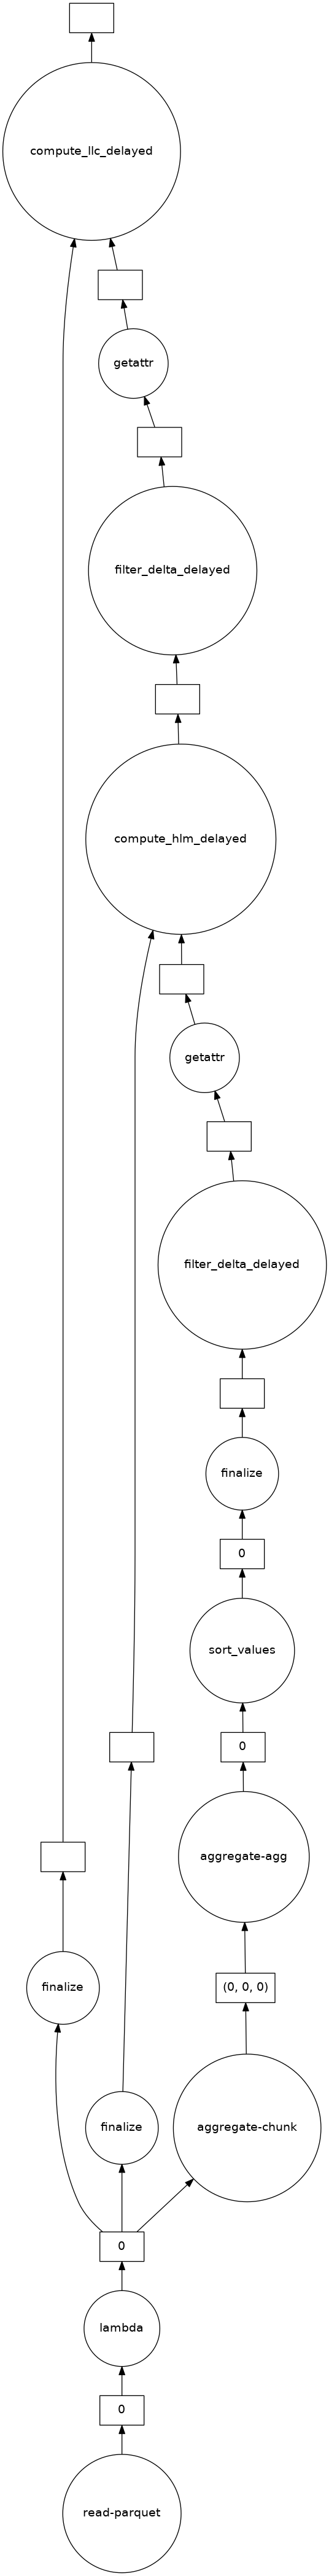

time: 204 ms (started: 2023-01-03 18:35:01 -08:00)


In [22]:
hlm_trange_filtered_file_id_filtered_llc.visualize()

In [142]:
hlm_file_id = compute_hlm(ddf=ddf, group_by='file_id')
hlm_file_id

,duration
,sum
npartitions=1,
,float32
,...


time: 42.6 ms (started: 2023-01-02 23:49:13 -08:00)
